<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/Evolution%20Strategy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=cbcd4b264504dd0630c28168c174865fdb9e06fe8933e51a04b56c72e2eab161
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [5]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [6]:
df = pd.read_csv('./Algorithmic_Trading/dataset/TSLA.csv')
df.head()

,PERMNO,date,PRC,VOL,OPENPRC,NUMTRD
0,93436,2010/06/29,23.89,19088009,19.00,81188
1,93436,2010/06/30,23.83,17607305,25.79,103154
2,93436,2010/07/01,21.96,8379501,25.00,44930
3,93436,2010/07/02,19.20,5255750,23.00,29684
4,93436,2010/07/06,16.11,7011230,20.00,37508


In [0]:
data = df[['PRC', 'VOL', 'OPENPRC']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//4
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*3 : (t + 1)*3] if d >= 0 else -d * [data[0], data[1], data[2]] + data[0 : (t + 1)*3]
    res = []
    for i in range(n - 1):
        for j in range(3):
            if block[i*3+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*3+j] - block[i*3+j])/block[i*3+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, validate, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.validate = validate
        self.buy = buy
        self.model=model

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, rewards).T
                )
            final_reward=self.reward_function(self.weights)
            if i>0:
                if final_reward>max(reward_list):
                    self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                if final_reward<np.average(reward_list):
                    self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),min(2*self.fsigma, 0.99))
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            if i==epoch-1:
                self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.validate,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money

            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size-dev_size-1]
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def validate(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(l-dev_size-test_size, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
            state = next_state
        if quantity>0:
            initial_money=initial_money+quantity*close[l-test_size]
        return ((initial_money - starting_money) / starting_money) * 100


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max(1, max_buy)
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                print(
                    'day %d, sell %d units at price %f, total balance %f,'
                    % (t, sell_units, total_sell, initial_money)
                )
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (now_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

iter 5. reward: 254.268474
day 1607: buy 5 units at price 907.250000, total balance 99092.750000
day 1608: buy 7 units at price 1286.390000, total balance 97806.360000
day 1609: buy 3 units at price 551.789970, total balance 97254.570030
day 1610: buy 2 units at price 377.320000, total balance 96877.250030
day 1612: buy 9 units at price 1660.680000, total balance 95216.570030
day 1613: buy 1 units at price 191.170000, total balance 95025.400030
day 1614: buy 1 units at price 193.140000, total balance 94832.260030
day 1615: buy 8 units at price 1573.199920, total balance 93259.060110
day 1618: buy 6 units at price 1136.399940, total balance 92122.660170
day 1622: buy 6 units at price 1115.100060, total balance 91007.560110
day 1625: buy 5 units at price 960.899950, total balance 90046.660160
day 1627: buy 1 units at price 198.149990, total balance 89848.510170
day 1628: buy 3 units at price 596.070000, total balance 89252.440170
day 1629: buy 6 units at price 1185.480000, total balance 

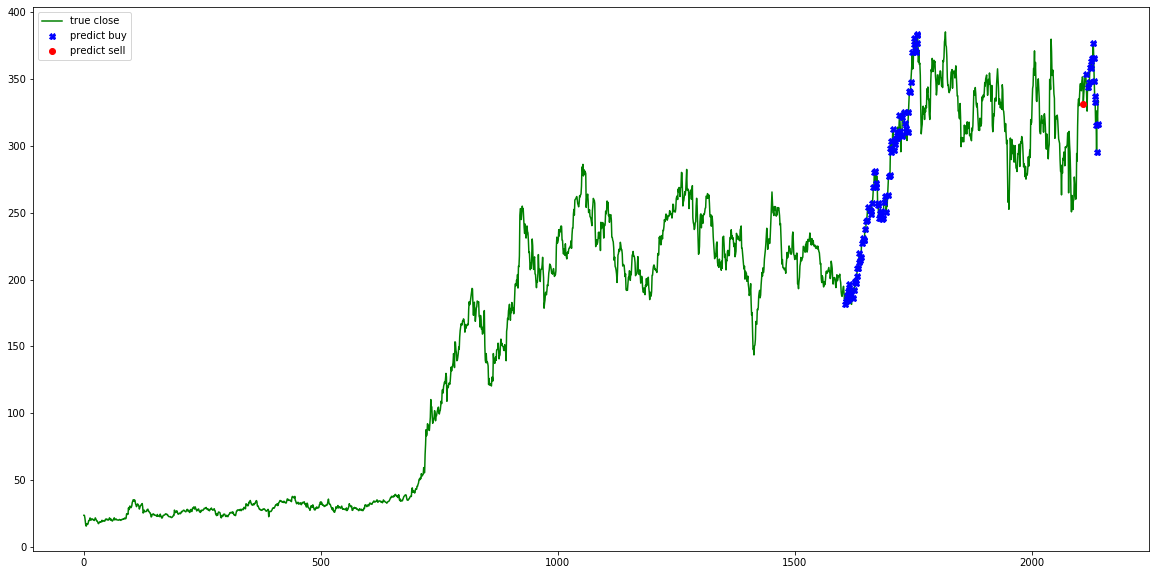

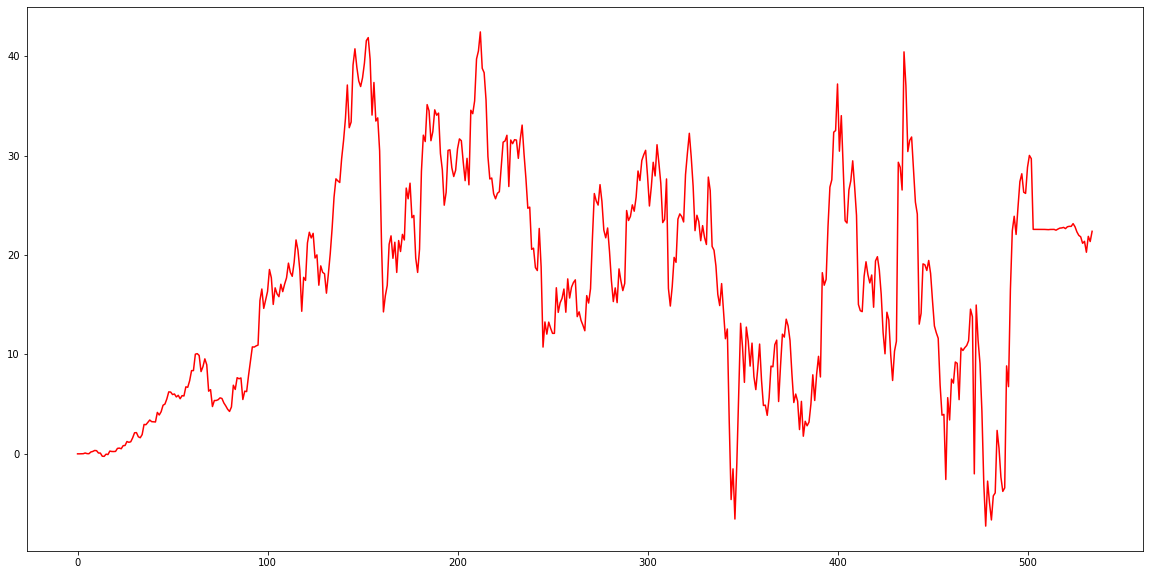

iter 10. reward: 523.266440
day 1606: buy 10 units at price 1885.600000, total balance 98114.400000
day 1608: buy 23 units at price 4226.710000, total balance 93887.690000
day 1609: buy 4 units at price 735.719960, total balance 93151.970040
day 1610: buy 8 units at price 1509.280000, total balance 91642.690040
day 1611: buy 11 units at price 2035.220000, total balance 89607.470040
day 1612: buy 9 units at price 1660.680000, total balance 87946.790040
day 1613: buy 1 units at price 191.170000, total balance 87755.620040
day 1614: buy 15 units at price 2897.100000, total balance 84858.520040
day 1615: buy 11 units at price 2163.149890, total balance 82695.370150
day 1618: buy 4 units at price 757.599960, total balance 81937.770190
day 1619: buy 8 units at price 1455.040000, total balance 80482.730190
day 1621: buy 10 units at price 1868.000000, total balance 78614.730190
day 1625: buy 20 units at price 3843.599800, total balance 74771.130390
day 1628: buy 13 units at price 2582.970000, 

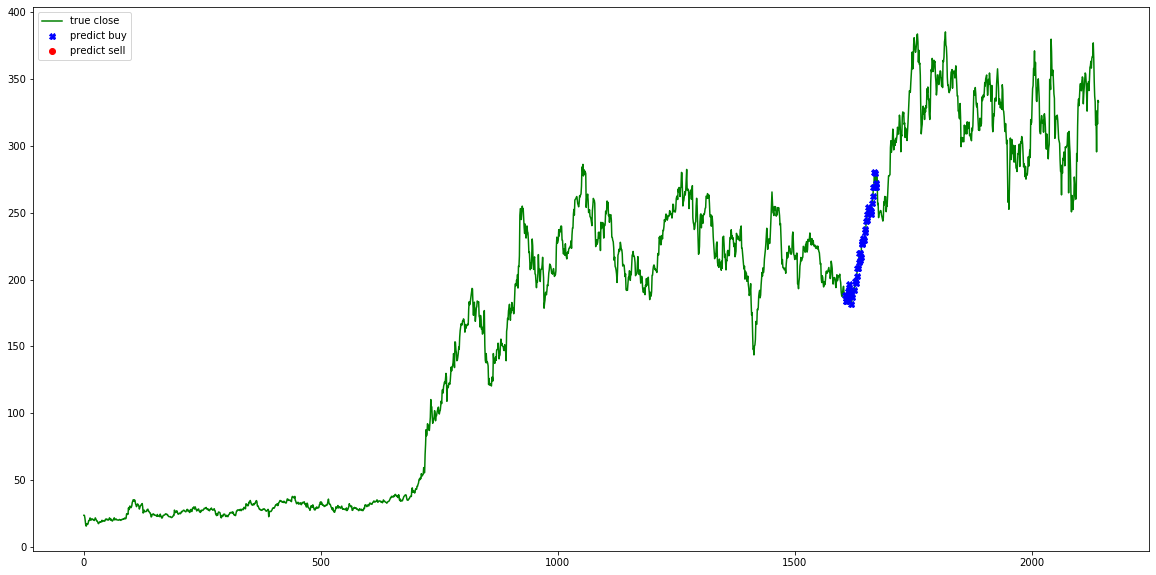

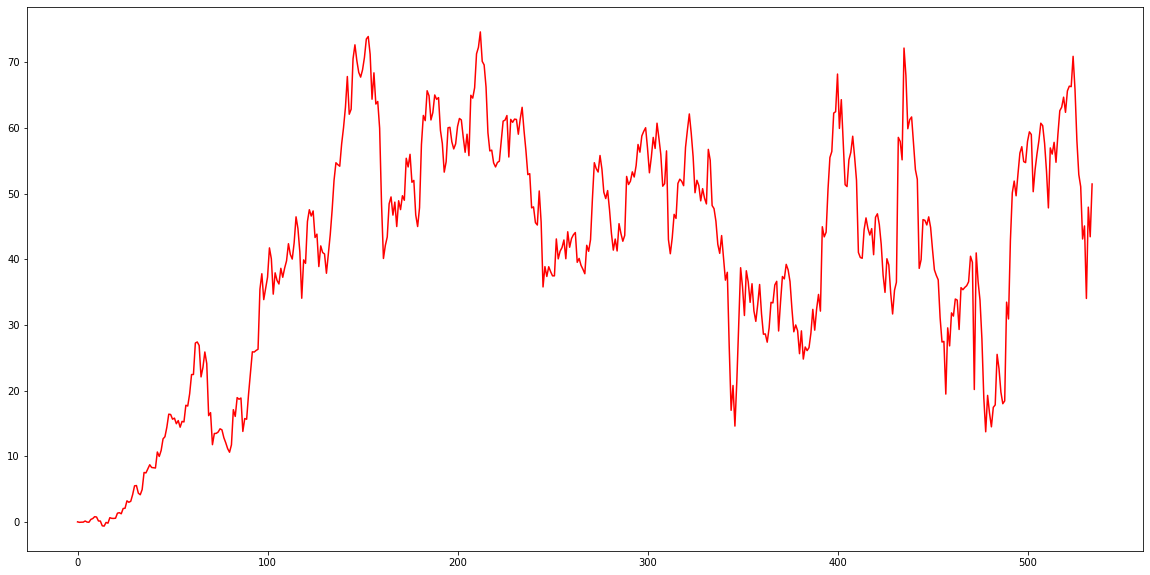

iter 15. reward: 562.820627
day 1606: buy 9 units at price 1697.040000, total balance 98302.960000
day 1608: buy 3 units at price 551.310000, total balance 97751.650000
day 1609: buy 3 units at price 551.789970, total balance 97199.860030
day 1610: buy 10 units at price 1886.600000, total balance 95313.260030
day 1611: buy 5 units at price 925.100000, total balance 94388.160030
day 1612: buy 11 units at price 2029.720000, total balance 92358.440030
day 1613: buy 11 units at price 2102.870000, total balance 90255.570030
day 1614: buy 16 units at price 3090.240000, total balance 87165.330030
day 1615: buy 13 units at price 2556.449870, total balance 84608.880160
day 1616: buy 23 units at price 4510.760000, total balance 80098.120160
day 1617: buy 5 units at price 947.850050, total balance 79150.270110
day 1618: buy 3 units at price 568.199970, total balance 78582.070140
day 1619: buy 6 units at price 1091.280000, total balance 77490.790140
day 1620: buy 1 units at price 181.470000, total

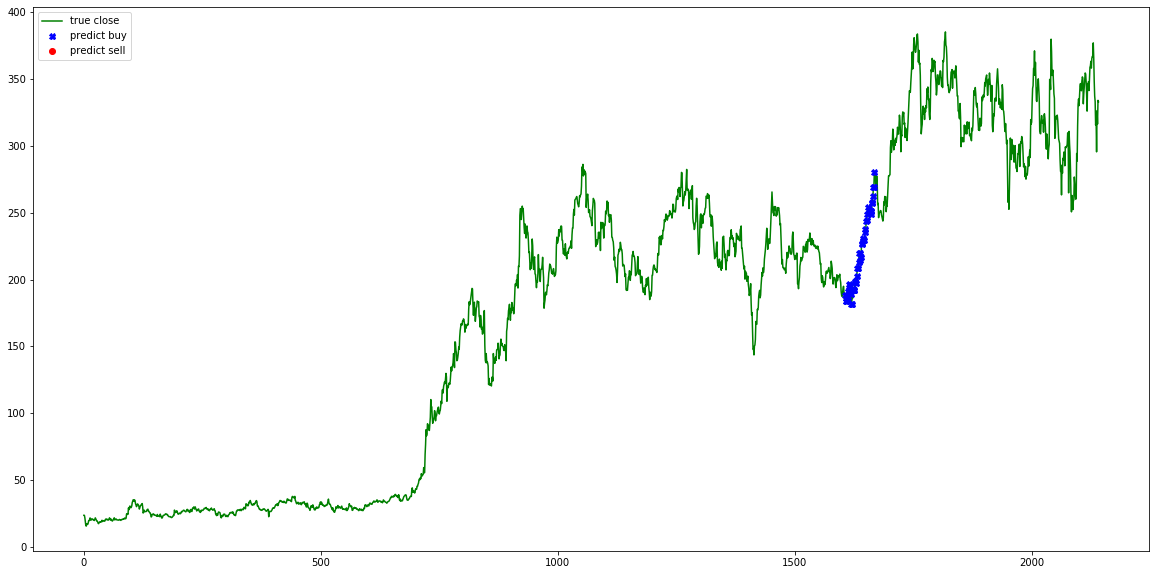

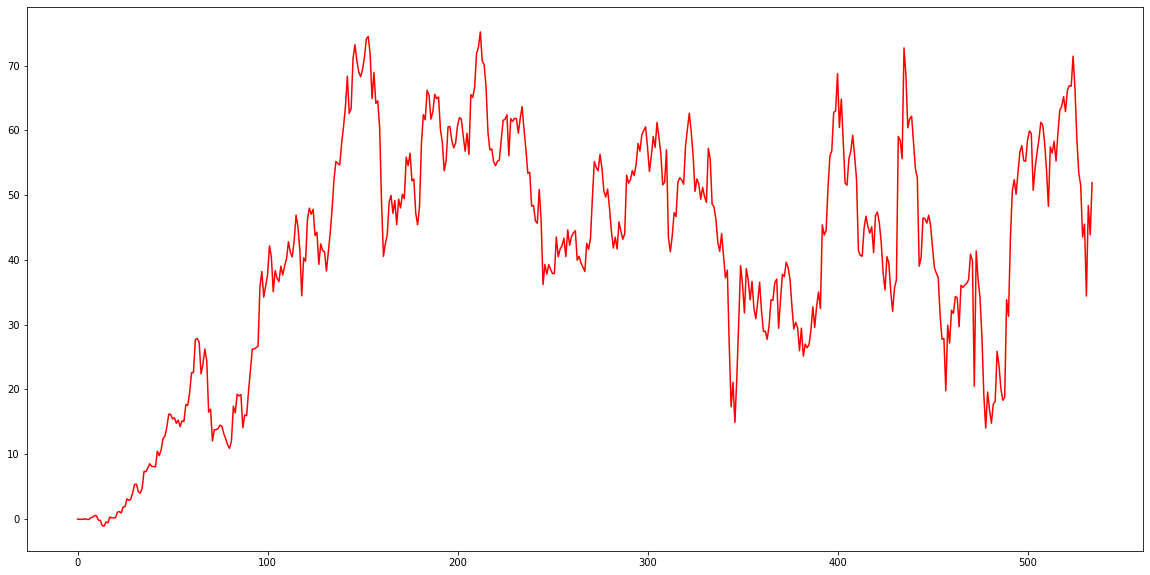

iter 20. reward: 61.466151
day 1606: buy 7 units at price 1319.920000, total balance 98680.080000
day 1608: buy 1 units at price 183.770000, total balance 98496.310000
day 1609: buy 1 units at price 183.929990, total balance 98312.380010
day 1610: buy 14 units at price 2641.240000, total balance 95671.140010
day 1611: buy 8 units at price 1480.160000, total balance 94190.980010
day 1612: buy 3 units at price 553.560000, total balance 93637.420010
day 1615: buy 1 units at price 196.649990, total balance 93440.770020
day 1616: buy 27 units at price 5295.240000, total balance 88145.530020
day 1618: buy 1 units at price 189.399990, total balance 87956.130030
day 1619: buy 16 units at price 2910.080000, total balance 85046.050030
day 1621: buy 1 units at price 186.800000, total balance 84859.250030
day 1623: buy 10 units at price 1931.499900, total balance 82927.750130
day 1624: buy 1 units at price 192.289990, total balance 82735.460140
day 1625: buy 14 units at price 2690.519860, total ba

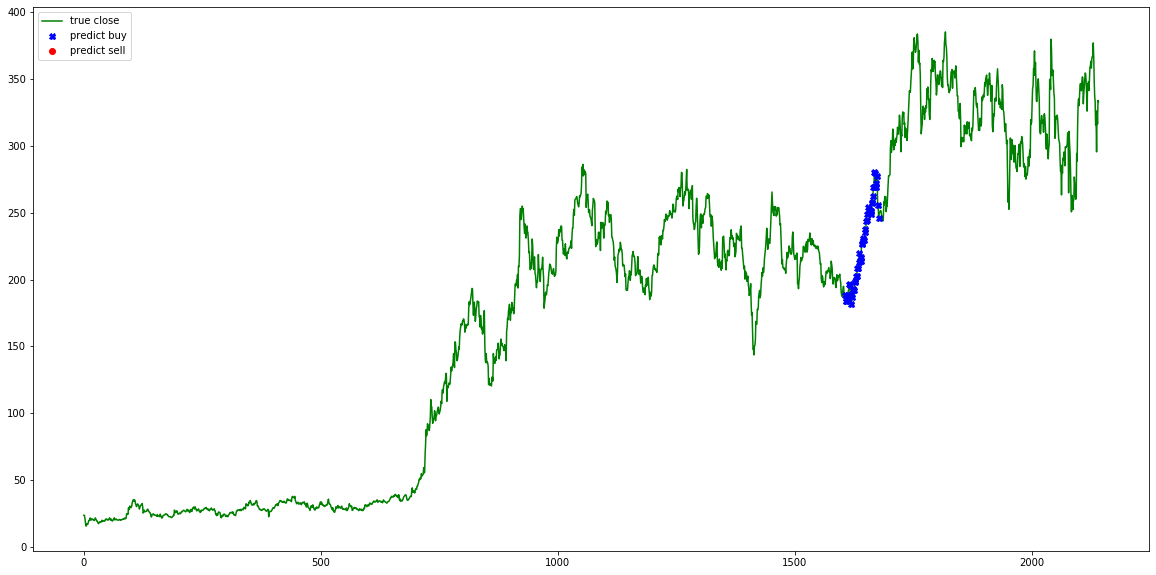

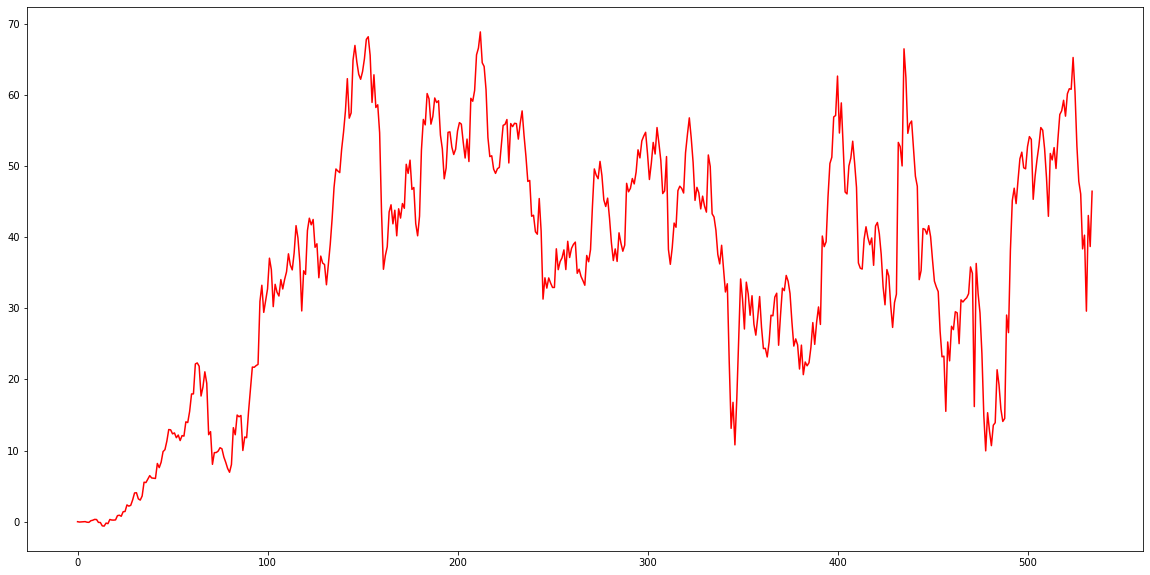

iter 25. reward: 559.129031
day 1606: buy 10 units at price 1885.600000, total balance 98114.400000
day 1608: buy 1 units at price 183.770000, total balance 97930.630000
day 1609: buy 1 units at price 183.929990, total balance 97746.700010
day 1611: buy 14 units at price 2590.280000, total balance 95156.420010
day 1612: buy 16 units at price 2952.320000, total balance 92204.100010
day 1615: buy 1 units at price 196.649990, total balance 92007.450020
day 1616: buy 29 units at price 5687.480000, total balance 86319.970020
day 1618: buy 2 units at price 378.799980, total balance 85941.170040
day 1619: buy 17 units at price 3091.960000, total balance 82849.210040
day 1621: buy 8 units at price 1494.400000, total balance 81354.810040
day 1623: buy 6 units at price 1158.899940, total balance 80195.910100
day 1624: buy 1 units at price 192.289990, total balance 80003.620110
day 1627: buy 7 units at price 1387.049930, total balance 78616.570180
day 1628: buy 13 units at price 2582.970000, tota

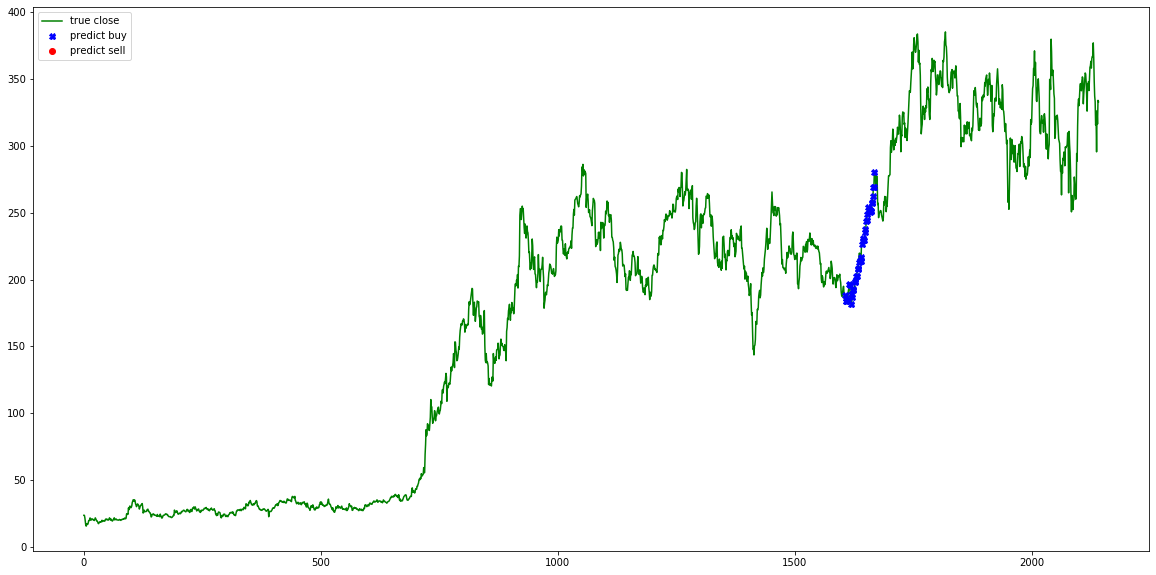

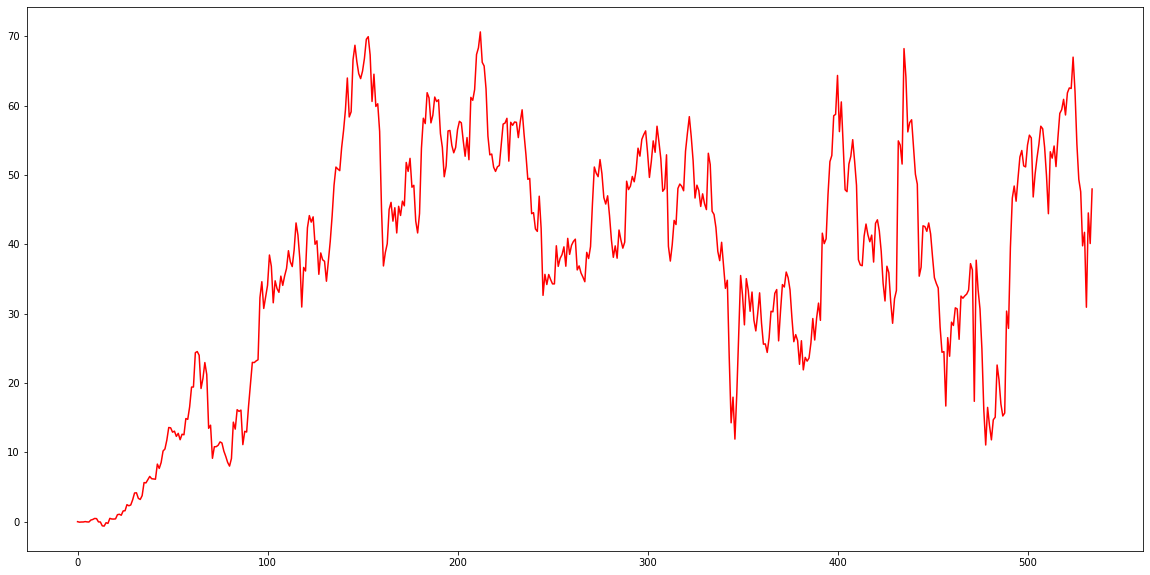

iter 30. reward: 541.152628
day 1606: buy 11 units at price 2074.160000, total balance 97925.840000
day 1608: buy 3 units at price 551.310000, total balance 97374.530000
day 1609: buy 1 units at price 183.929990, total balance 97190.600010
day 1611: buy 18 units at price 3330.360000, total balance 93860.240010
day 1612: buy 12 units at price 2214.240000, total balance 91646.000010
day 1615: buy 1 units at price 196.649990, total balance 91449.350020
day 1616: buy 26 units at price 5099.120000, total balance 86350.230020
day 1617: buy 12 units at price 2274.840120, total balance 84075.389900
day 1618: buy 1 units at price 189.399990, total balance 83885.989910
day 1619: buy 7 units at price 1273.160000, total balance 82612.829910
day 1621: buy 4 units at price 747.200000, total balance 81865.629910
day 1624: buy 1 units at price 192.289990, total balance 81673.339920
day 1625: buy 18 units at price 3459.239820, total balance 78214.100100
day 1627: buy 1 units at price 198.149990, total 

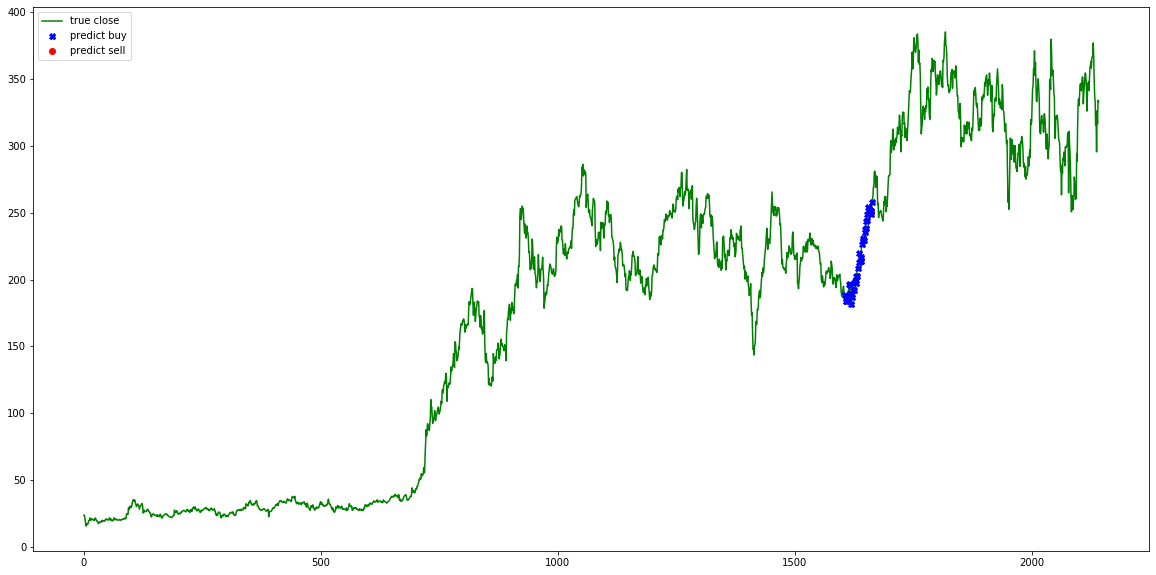

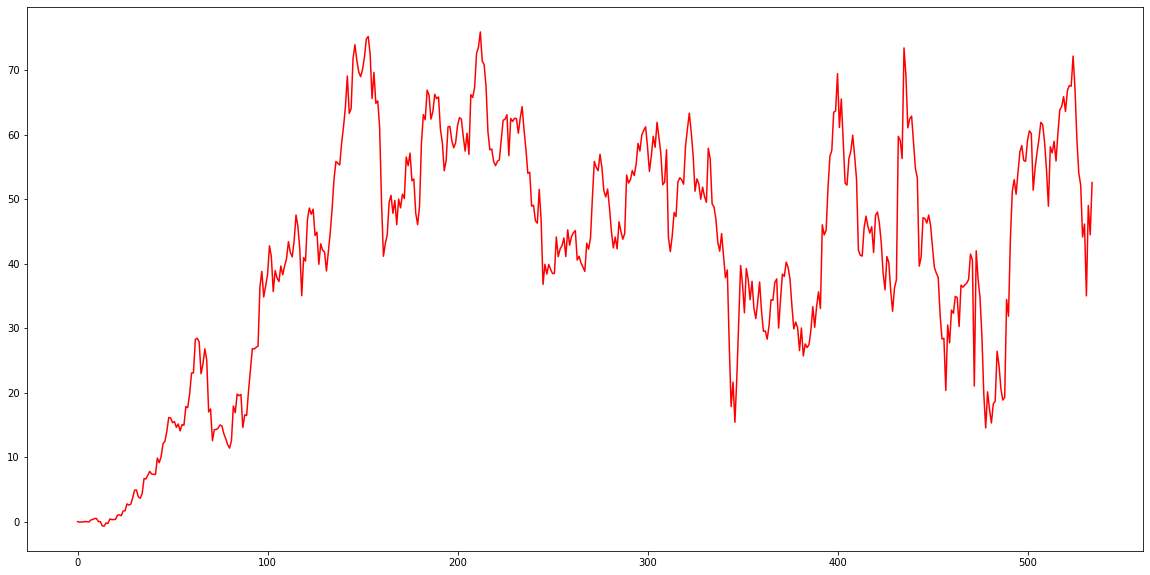

iter 35. reward: 627.871472
day 1606: buy 19 units at price 3582.640000, total balance 96417.360000
day 1608: buy 5 units at price 918.850000, total balance 95498.510000
day 1609: buy 1 units at price 183.929990, total balance 95314.580010
day 1610: buy 20 units at price 3773.200000, total balance 91541.380010
day 1611: buy 20 units at price 3700.400000, total balance 87840.980010
day 1612: buy 1 units at price 184.520000, total balance 87656.460010
day 1613: buy 33 units at price 6308.610000, total balance 81347.850010
day 1615: buy 1 units at price 196.649990, total balance 81151.200020
day 1616: buy 36 units at price 7060.320000, total balance 74090.880020
day 1617: buy 25 units at price 4739.250250, total balance 69351.629770
day 1618: buy 1 units at price 189.399990, total balance 69162.229780
day 1619: buy 25 units at price 4547.000000, total balance 64615.229780
day 1620: buy 19 units at price 3447.930000, total balance 61167.299780
day 1621: buy 1 units at price 186.800000, tot

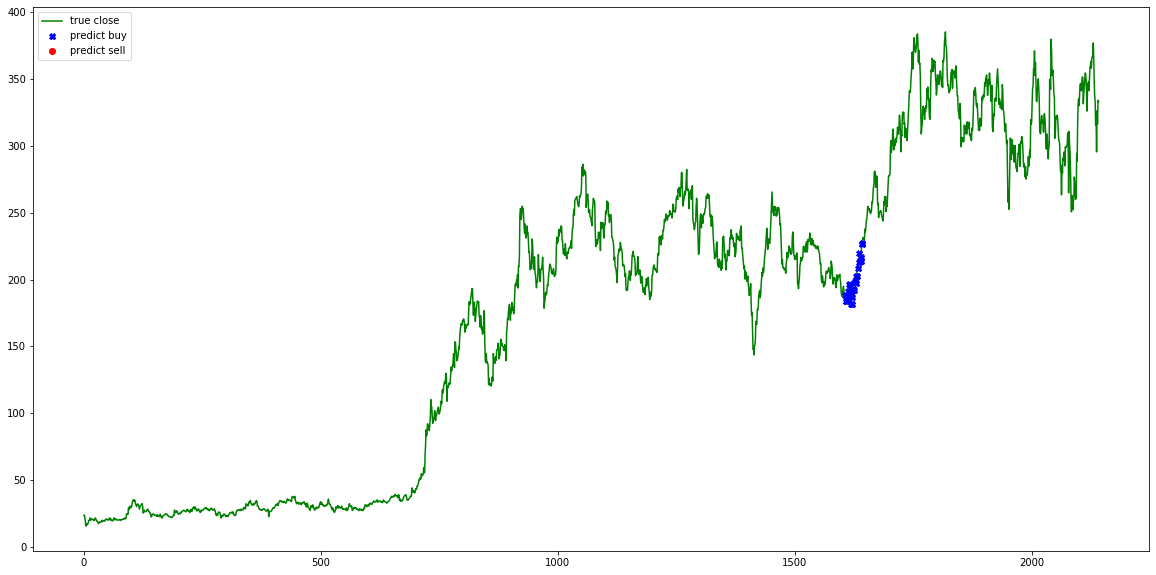

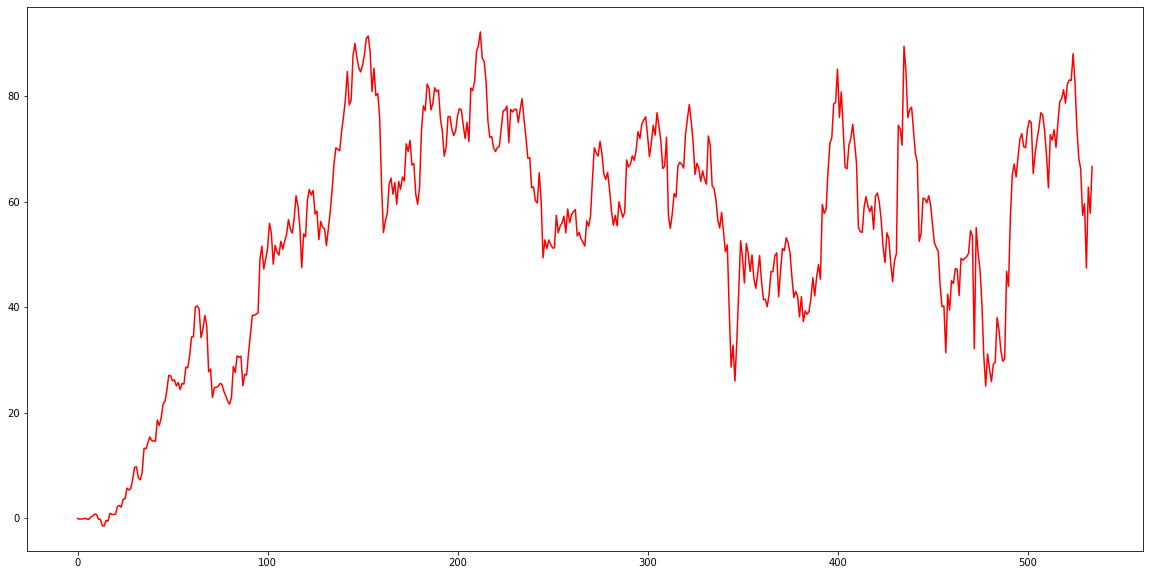

iter 40. reward: 882.580973
day 1606: buy 27 units at price 5091.120000, total balance 94908.880000
day 1608: buy 18 units at price 3307.860000, total balance 91601.020000
day 1609: buy 1 units at price 183.929990, total balance 91417.090010
day 1610: buy 22 units at price 4150.520000, total balance 87266.570010
day 1611: buy 31 units at price 5735.620000, total balance 81530.950010
day 1612: buy 1 units at price 184.520000, total balance 81346.430010
day 1613: buy 48 units at price 9176.160000, total balance 72170.270010
day 1614: buy 27 units at price 5214.780000, total balance 66955.490010
day 1615: buy 1 units at price 196.649990, total balance 66758.840020
day 1616: buy 22 units at price 4314.640000, total balance 62444.200020
day 1617: buy 24 units at price 4549.680240, total balance 57894.519780
day 1618: buy 9 units at price 1704.599910, total balance 56189.919870
day 1619: buy 33 units at price 6002.040000, total balance 50187.879870
day 1620: buy 33 units at price 5988.510000

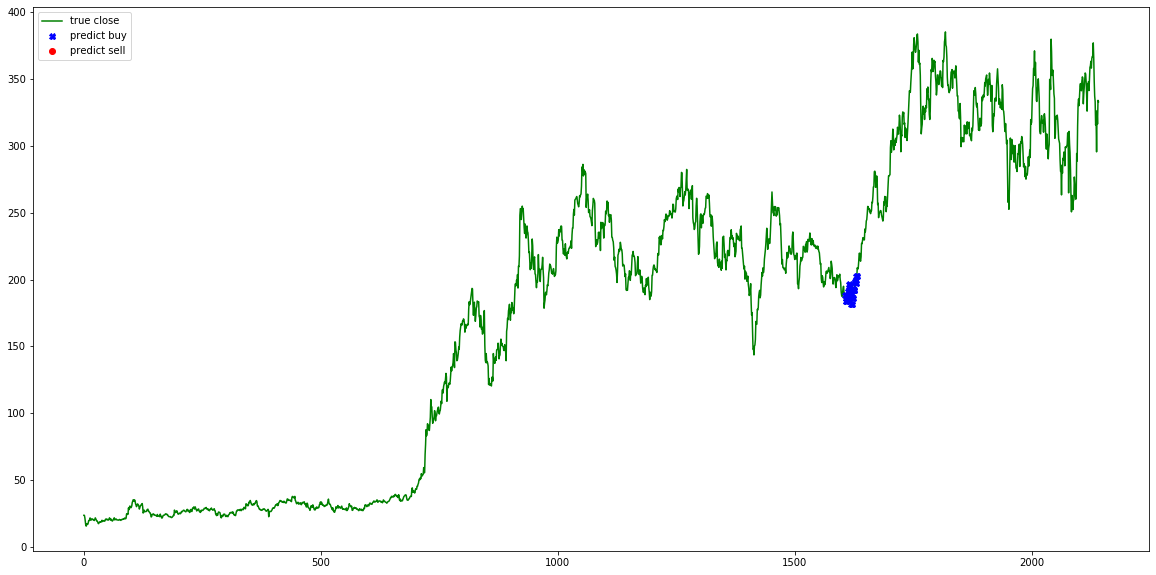

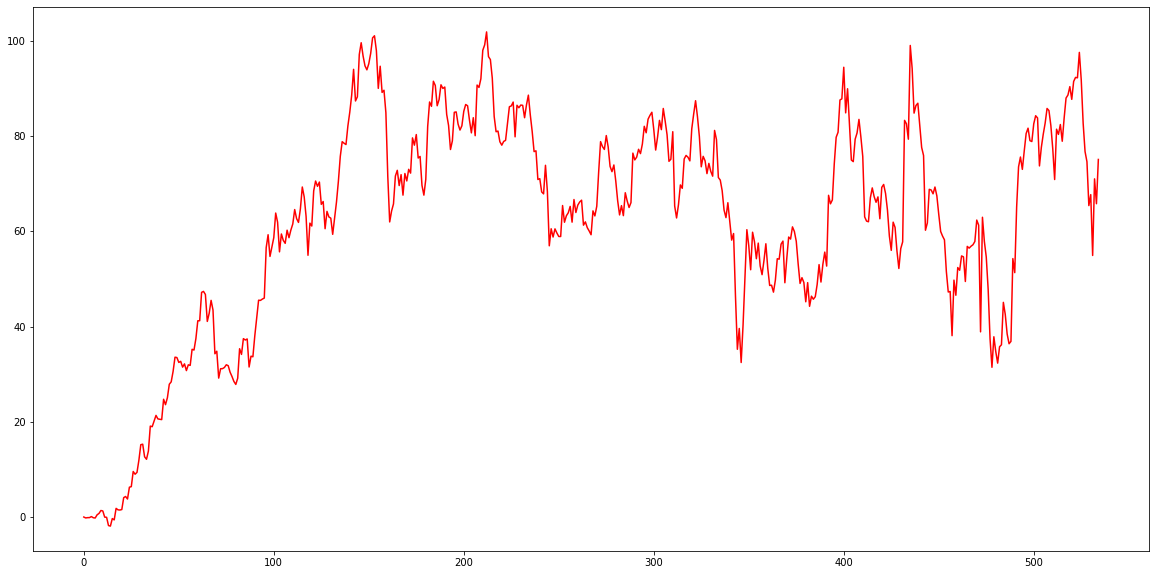

iter 45. reward: 625.288358
day 1606: buy 20 units at price 3771.200000, total balance 96228.800000
day 1608: buy 28 units at price 5145.560000, total balance 91083.240000
day 1610: buy 11 units at price 2075.260000, total balance 89007.980000
day 1611: buy 26 units at price 4810.520000, total balance 84197.460000
day 1612: buy 2 units at price 369.040000, total balance 83828.420000
day 1613: buy 56 units at price 10705.520000, total balance 73122.900000
day 1614: buy 19 units at price 3669.660000, total balance 69453.240000
day 1616: buy 22 units at price 4314.640000, total balance 65138.600000
day 1618: buy 9 units at price 1704.599910, total balance 63434.000090
day 1619: buy 37 units at price 6729.560000, total balance 56704.440090
day 1620: buy 24 units at price 4355.280000, total balance 52349.160090
day 1621: buy 8 units at price 1494.400000, total balance 50854.760090
day 1622: buy 40 units at price 7434.000400, total balance 43420.759690
day 1623: buy 15 units at price 2897.24

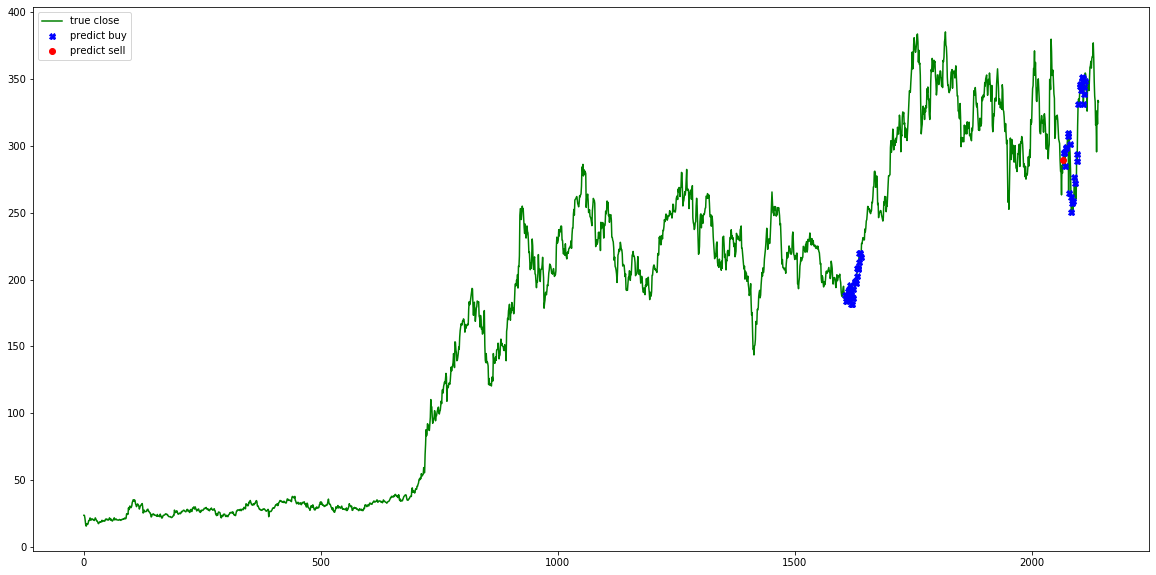

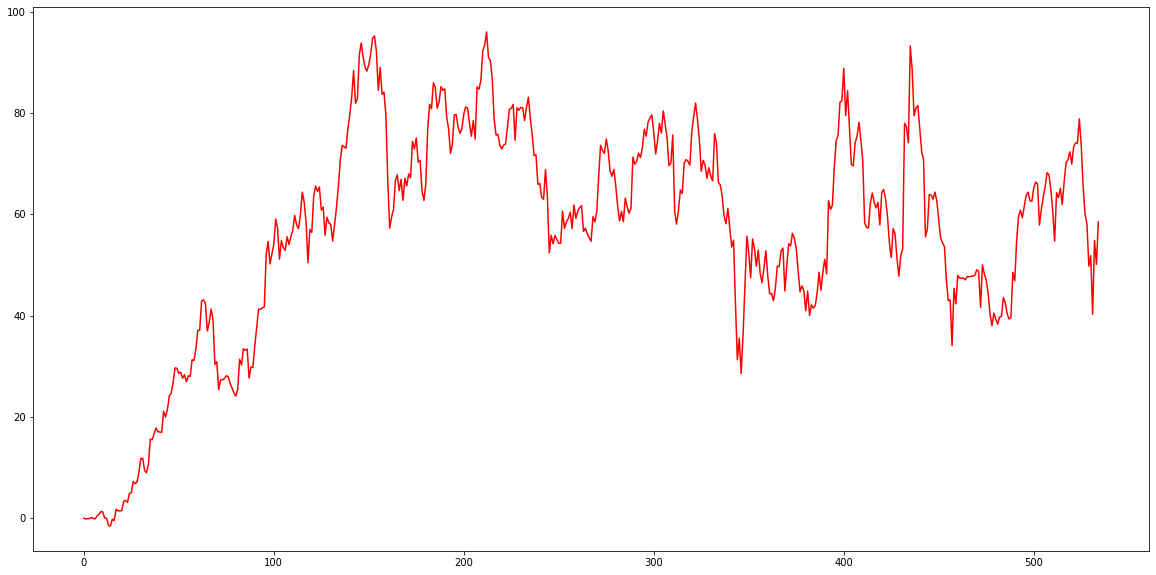

iter 50. reward: 862.123968
day 1606: buy 18 units at price 3394.080000, total balance 96605.920000
day 1608: buy 21 units at price 3859.170000, total balance 92746.750000
day 1610: buy 21 units at price 3961.860000, total balance 88784.890000
day 1611: buy 21 units at price 3885.420000, total balance 84899.470000
day 1613: buy 56 units at price 10705.520000, total balance 74193.950000
day 1614: buy 7 units at price 1351.980000, total balance 72841.970000
day 1616: buy 38 units at price 7452.560000, total balance 65389.410000
day 1617: buy 11 units at price 2085.270110, total balance 63304.139890
day 1618: buy 1 units at price 189.399990, total balance 63114.739900
day 1619: buy 49 units at price 8912.120000, total balance 54202.619900
day 1620: buy 12 units at price 2177.640000, total balance 52024.979900
day 1621: buy 2 units at price 373.600000, total balance 51651.379900
day 1622: buy 52 units at price 9664.200520, total balance 41987.179380
day 1623: buy 1 units at price 193.14999

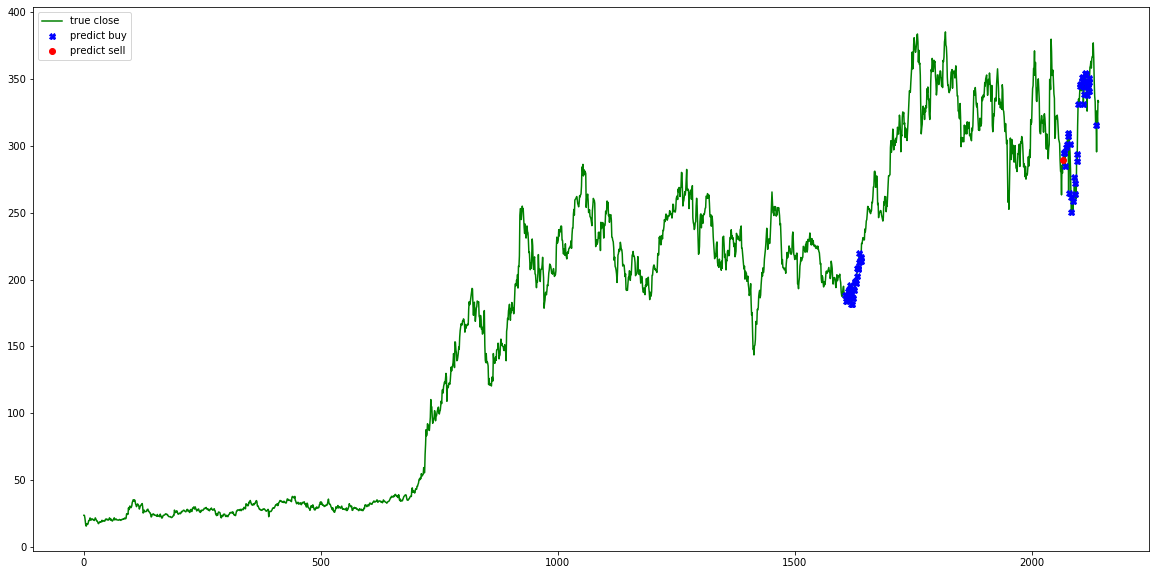

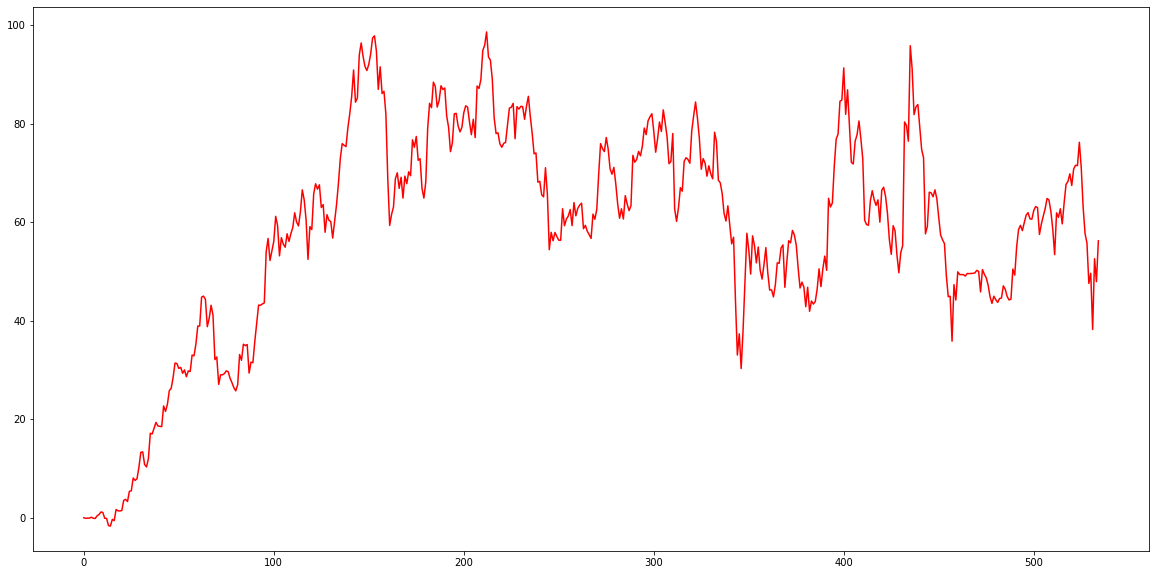

iter 55. reward: 960.434647
day 1606: buy 15 units at price 2828.400000, total balance 97171.600000
day 1608: buy 3 units at price 551.310000, total balance 96620.290000
day 1610: buy 9 units at price 1697.940000, total balance 94922.350000
day 1611: buy 33 units at price 6105.660000, total balance 88816.690000
day 1612: buy 19 units at price 3505.880000, total balance 85310.810000
day 1613: buy 47 units at price 8984.990000, total balance 76325.820000
day 1614: buy 1 units at price 193.140000, total balance 76132.680000
day 1616: buy 28 units at price 5491.360000, total balance 70641.320000
day 1617: buy 1 units at price 189.570010, total balance 70451.749990
day 1618: buy 3 units at price 568.199970, total balance 69883.550020
day 1619: buy 54 units at price 9821.520000, total balance 60062.030020
day 1620: buy 1 units at price 181.470000, total balance 59880.560020
day 1621: buy 1 units at price 186.800000, total balance 59693.760020
day 1622: buy 49 units at price 9106.650490, tota

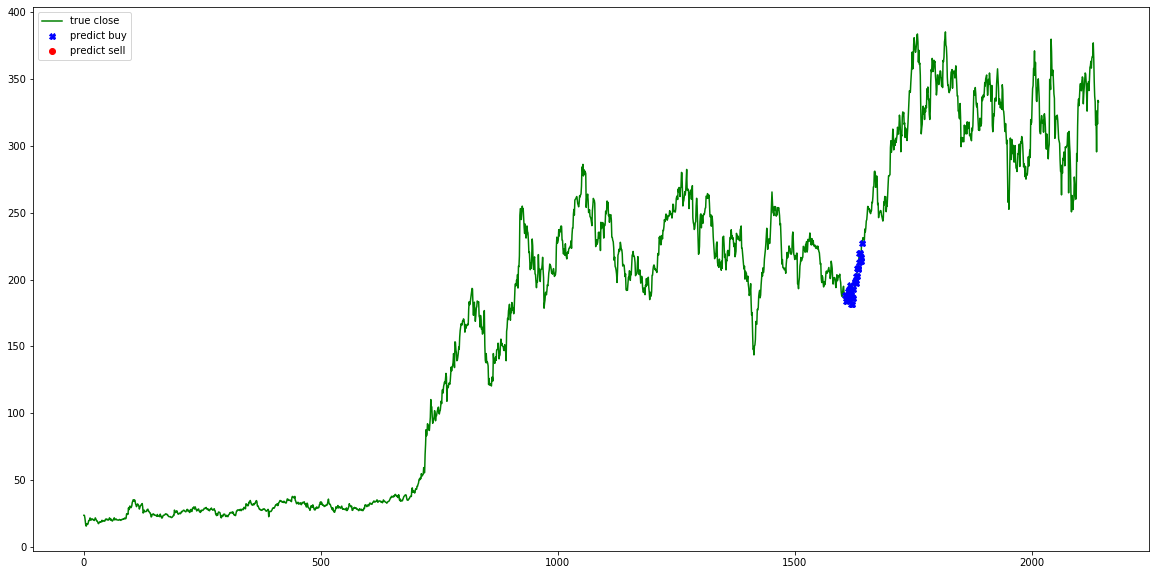

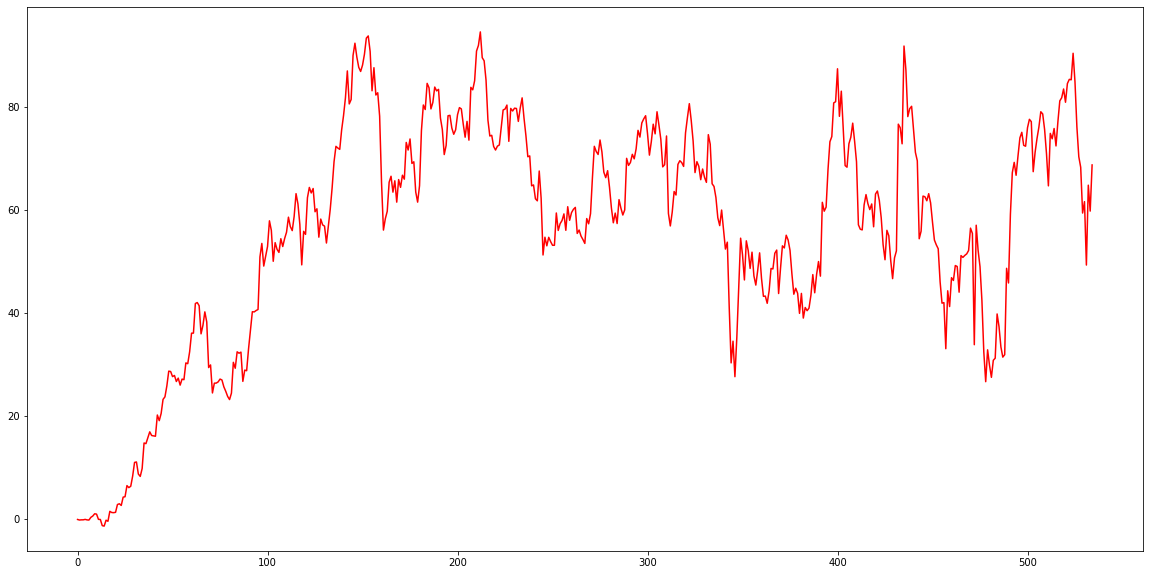

iter 60. reward: 829.008888
day 1606: buy 21 units at price 3959.760000, total balance 96040.240000
day 1608: buy 9 units at price 1653.930000, total balance 94386.310000
day 1611: buy 53 units at price 9806.060000, total balance 84580.250000
day 1612: buy 45 units at price 8303.400000, total balance 76276.850000
day 1613: buy 36 units at price 6882.120000, total balance 69394.730000
day 1614: buy 1 units at price 193.140000, total balance 69201.590000
day 1615: buy 1 units at price 196.649990, total balance 69004.940010
day 1616: buy 26 units at price 5099.120000, total balance 63905.820010
day 1618: buy 12 units at price 2272.799880, total balance 61633.020130
day 1619: buy 56 units at price 10185.280000, total balance 51447.740130
day 1620: buy 1 units at price 181.470000, total balance 51266.270130
day 1621: buy 9 units at price 1681.200000, total balance 49585.070130
day 1622: buy 45 units at price 8363.250450, total balance 41221.819680
day 1623: buy 1 units at price 193.149990, 

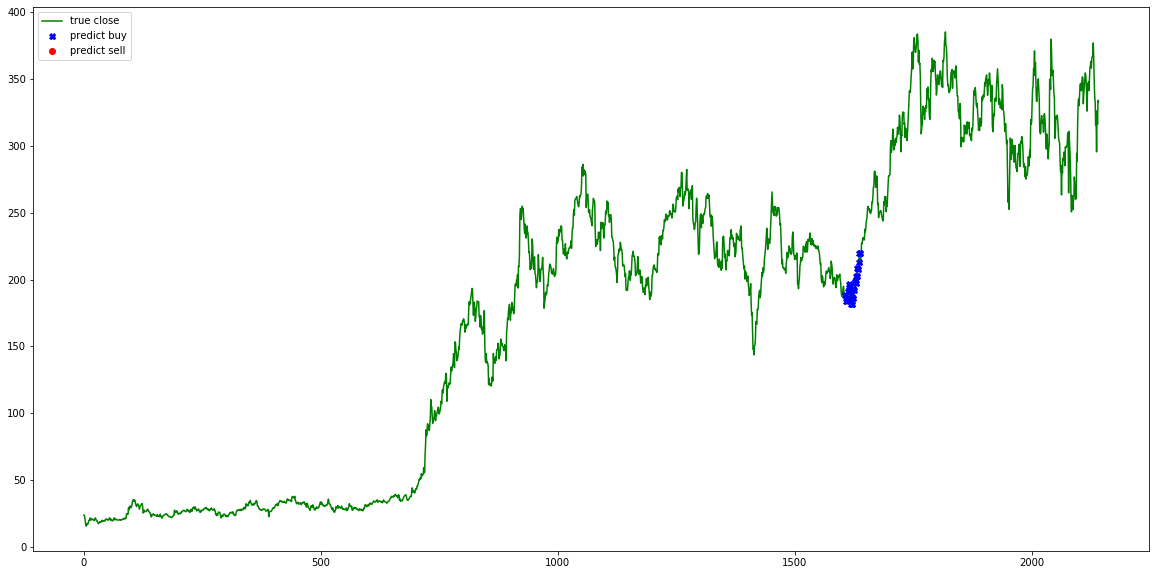

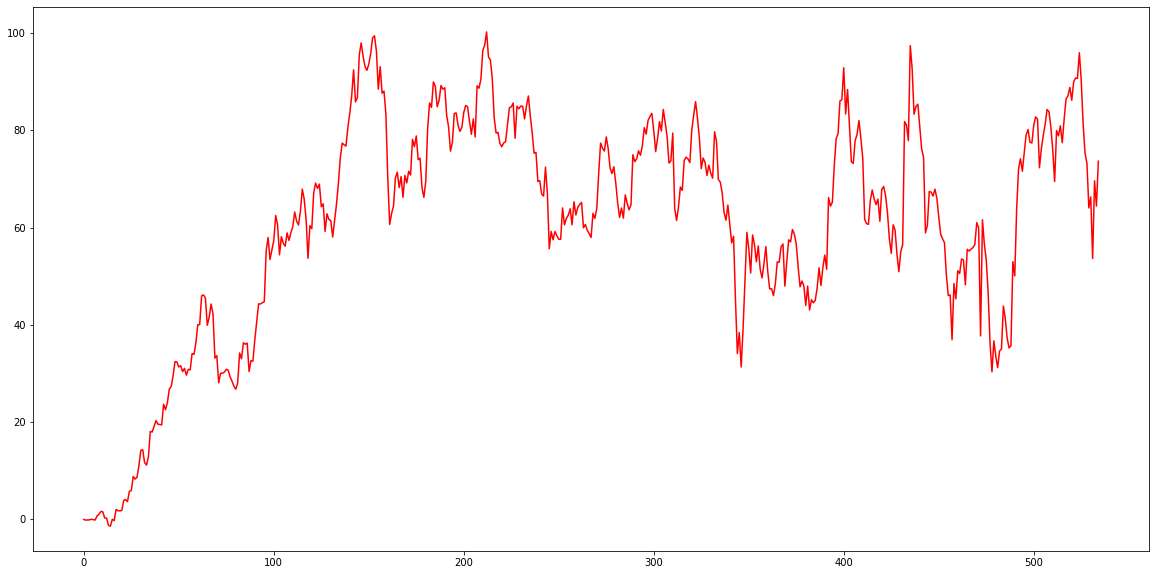

iter 65. reward: 1162.029182
day 1606: buy 30 units at price 5656.800000, total balance 94343.200000
day 1608: buy 4 units at price 735.080000, total balance 93608.120000
day 1609: buy 1 units at price 183.929990, total balance 93424.190010
day 1611: buy 52 units at price 9621.040000, total balance 83803.150010
day 1612: buy 42 units at price 7749.840000, total balance 76053.310010
day 1613: buy 7 units at price 1338.190000, total balance 74715.120010
day 1614: buy 1 units at price 193.140000, total balance 74521.980010
day 1615: buy 1 units at price 196.649990, total balance 74325.330020
day 1616: buy 26 units at price 5099.120000, total balance 69226.210020
day 1617: buy 1 units at price 189.570010, total balance 69036.640010
day 1618: buy 21 units at price 3977.399790, total balance 65059.240220
day 1619: buy 66 units at price 12004.080000, total balance 53055.160220
day 1620: buy 1 units at price 181.470000, total balance 52873.690220
day 1622: buy 41 units at price 7619.850410, to

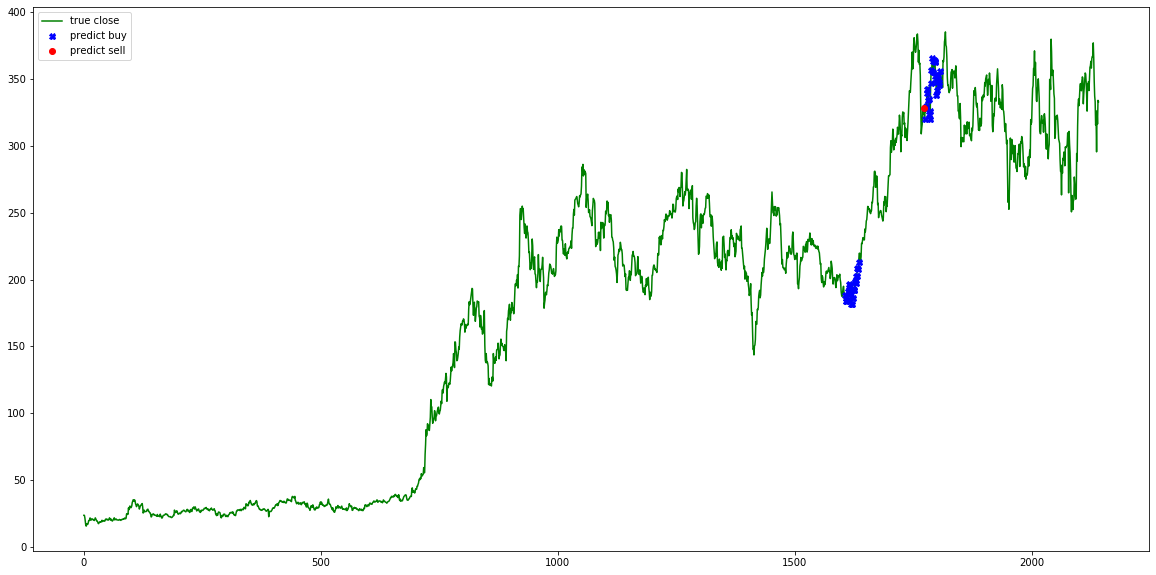

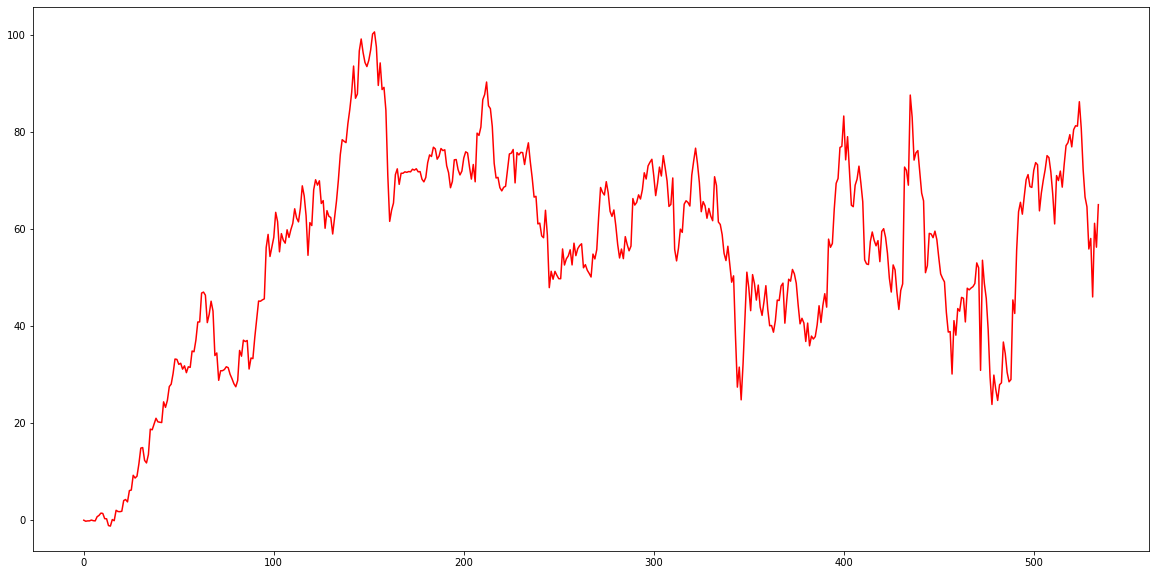

iter 70. reward: 1086.954760
day 1606: buy 42 units at price 7919.520000, total balance 92080.480000
day 1607: buy 24 units at price 4354.800000, total balance 87725.680000
day 1608: buy 1 units at price 183.770000, total balance 87541.910000
day 1609: buy 1 units at price 183.929990, total balance 87357.980010
day 1610: buy 26 units at price 4905.160000, total balance 82452.820010
day 1611: buy 62 units at price 11471.240000, total balance 70981.580010
day 1612: buy 54 units at price 9964.080000, total balance 61017.500010
day 1614: buy 1 units at price 193.140000, total balance 60824.360010
day 1615: buy 1 units at price 196.649990, total balance 60627.710020
day 1616: buy 11 units at price 2157.320000, total balance 58470.390020
day 1617: buy 15 units at price 2843.550150, total balance 55626.839870
day 1618: buy 40 units at price 7575.999600, total balance 48050.840270
day 1619: buy 47 units at price 8548.360000, total balance 39502.480270
day 1620: buy 8 units at price 1451.760000

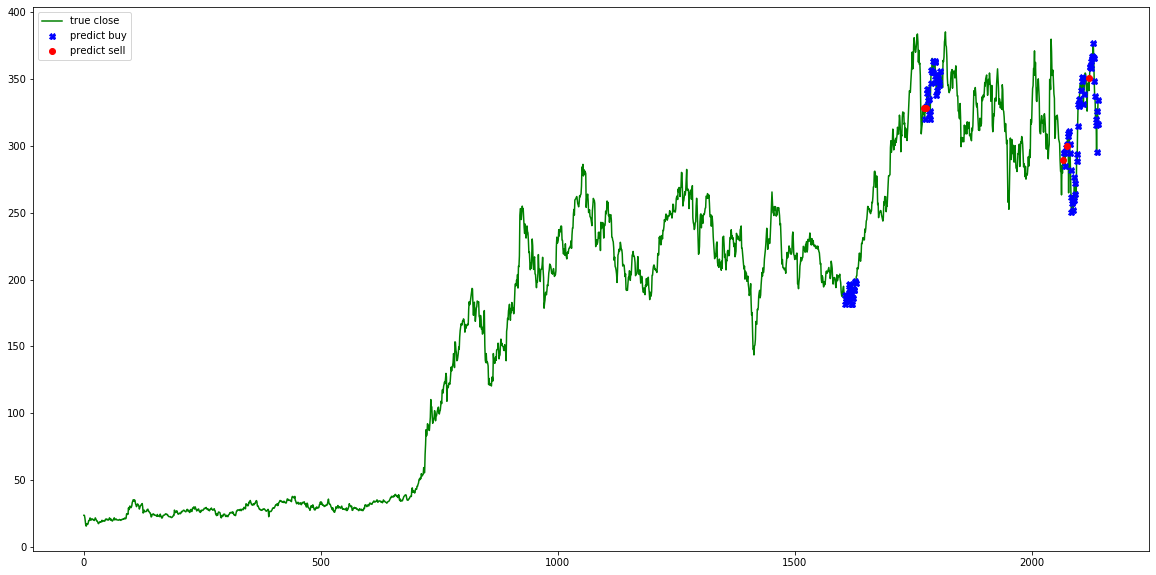

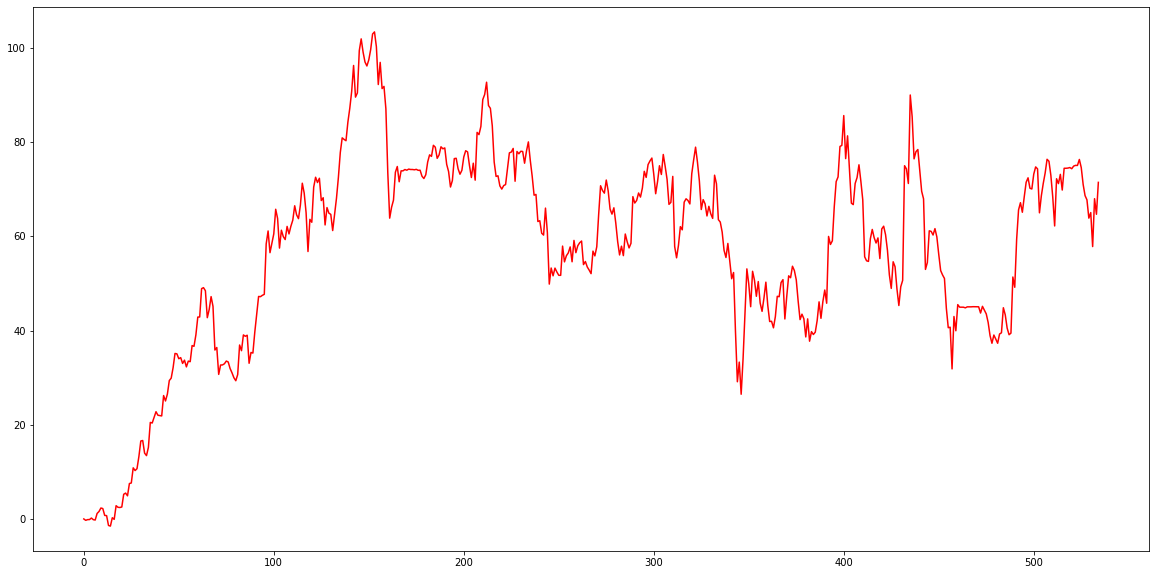

iter 75. reward: 1146.552446
day 1606: buy 35 units at price 6599.600000, total balance 93400.400000
day 1607: buy 16 units at price 2903.200000, total balance 90497.200000
day 1608: buy 10 units at price 1837.700000, total balance 88659.500000
day 1609: buy 8 units at price 1471.439920, total balance 87188.060080
day 1610: buy 14 units at price 2641.240000, total balance 84546.820080
day 1611: buy 53 units at price 9806.060000, total balance 74740.760080
day 1612: buy 34 units at price 6273.680000, total balance 68467.080080
day 1613: buy 6 units at price 1147.020000, total balance 67320.060080
day 1614: buy 1 units at price 193.140000, total balance 67126.920080
day 1615: buy 1 units at price 196.649990, total balance 66930.270090
day 1616: buy 11 units at price 2157.320000, total balance 64772.950090
day 1617: buy 23 units at price 4360.110230, total balance 60412.839860
day 1618: buy 26 units at price 4924.399740, total balance 55488.440120
day 1619: buy 54 units at price 9821.5200

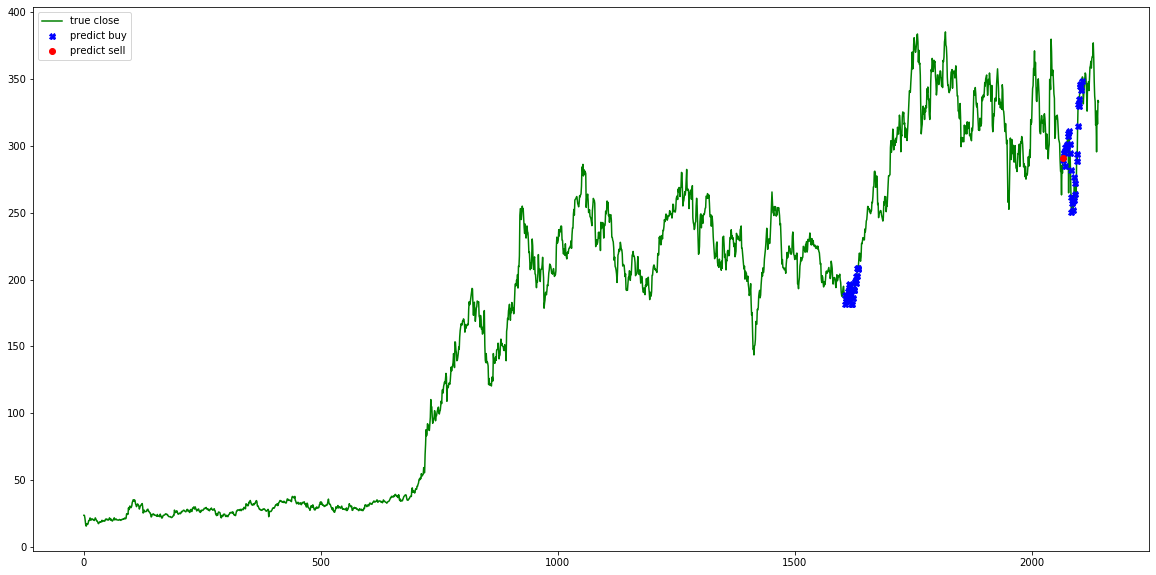

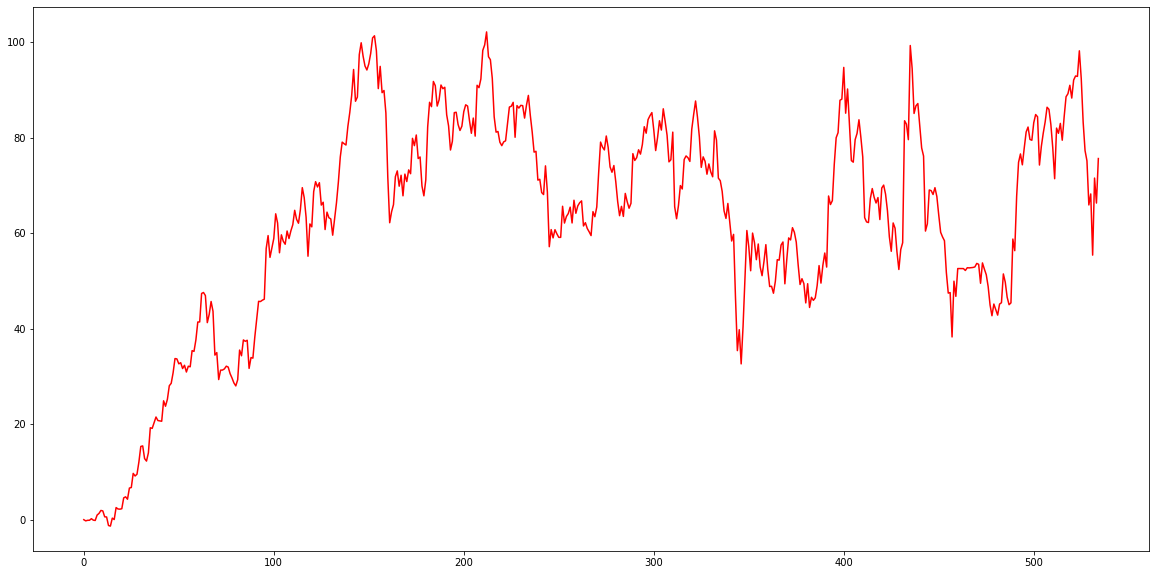

iter 80. reward: 1008.007785
day 1606: buy 43 units at price 8108.080000, total balance 91891.920000
day 1607: buy 22 units at price 3991.900000, total balance 87900.020000
day 1608: buy 12 units at price 2205.240000, total balance 85694.780000
day 1609: buy 14 units at price 2575.019860, total balance 83119.760140
day 1610: buy 35 units at price 6603.100000, total balance 76516.660140
day 1611: buy 56 units at price 10361.120000, total balance 66155.540140
day 1612: buy 31 units at price 5720.120000, total balance 60435.420140
day 1613: buy 1 units at price 191.170000, total balance 60244.250140
day 1614: buy 1 units at price 193.140000, total balance 60051.110140
day 1615: buy 1 units at price 196.649990, total balance 59854.460150
day 1616: buy 1 units at price 196.120000, total balance 59658.340150
day 1617: buy 38 units at price 7203.660380, total balance 52454.679770
day 1618: buy 27 units at price 5113.799730, total balance 47340.880040
day 1619: buy 52 units at price 9457.76000

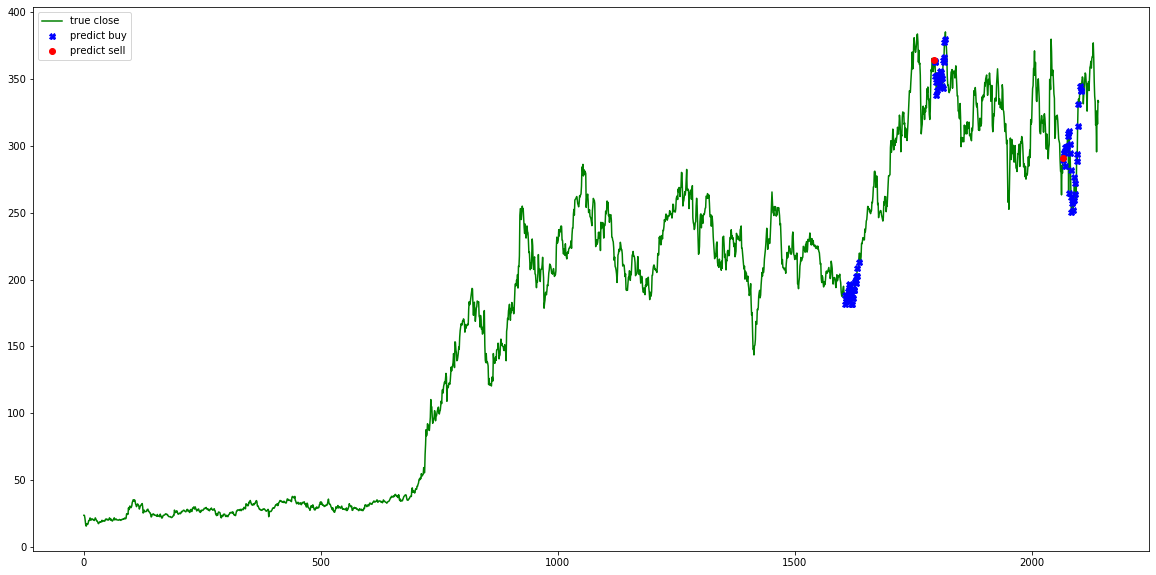

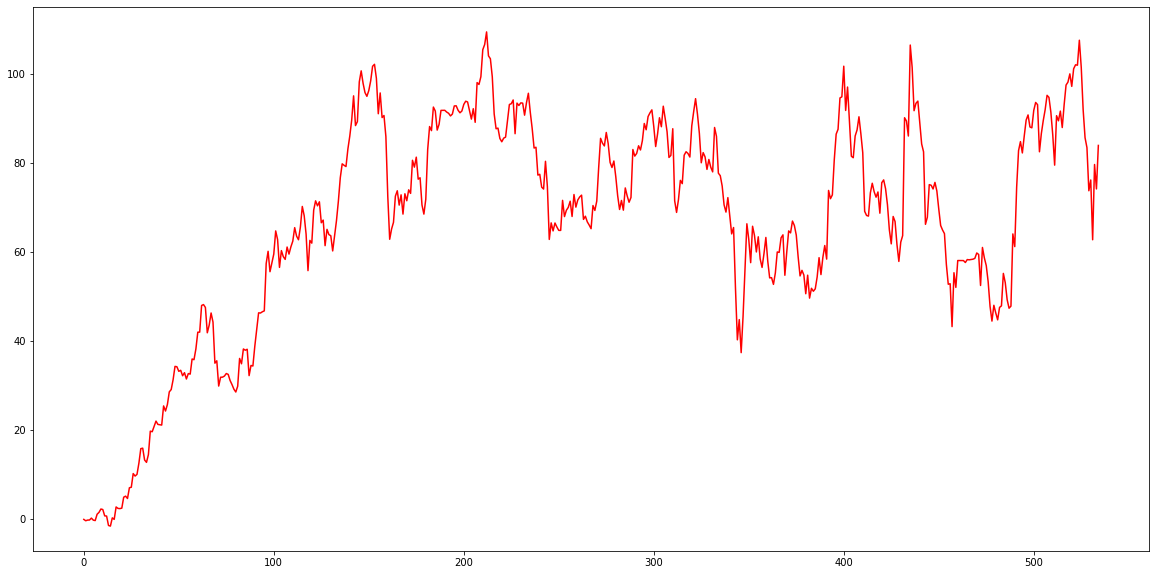

iter 85. reward: 1024.254010
day 1606: buy 39 units at price 7353.840000, total balance 92646.160000
day 1607: buy 21 units at price 3810.450000, total balance 88835.710000
day 1608: buy 11 units at price 2021.470000, total balance 86814.240000
day 1609: buy 6 units at price 1103.579940, total balance 85710.660060
day 1610: buy 29 units at price 5471.140000, total balance 80239.520060
day 1611: buy 70 units at price 12951.400000, total balance 67288.120060
day 1612: buy 47 units at price 8672.440000, total balance 58615.680060
day 1613: buy 4 units at price 764.680000, total balance 57851.000060
day 1614: buy 8 units at price 1545.120000, total balance 56305.880060
day 1616: buy 1 units at price 196.120000, total balance 56109.760060
day 1617: buy 31 units at price 5876.670310, total balance 50233.089750
day 1618: buy 40 units at price 7575.999600, total balance 42657.090150
day 1619: buy 51 units at price 9275.880000, total balance 33381.210150
day 1620: buy 20 units at price 3629.400

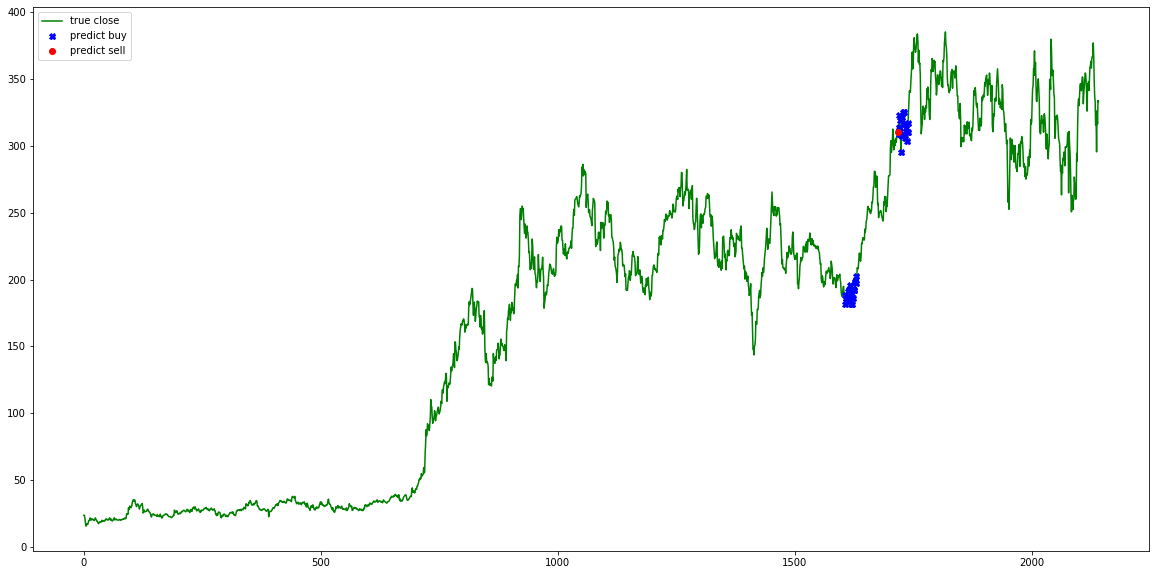

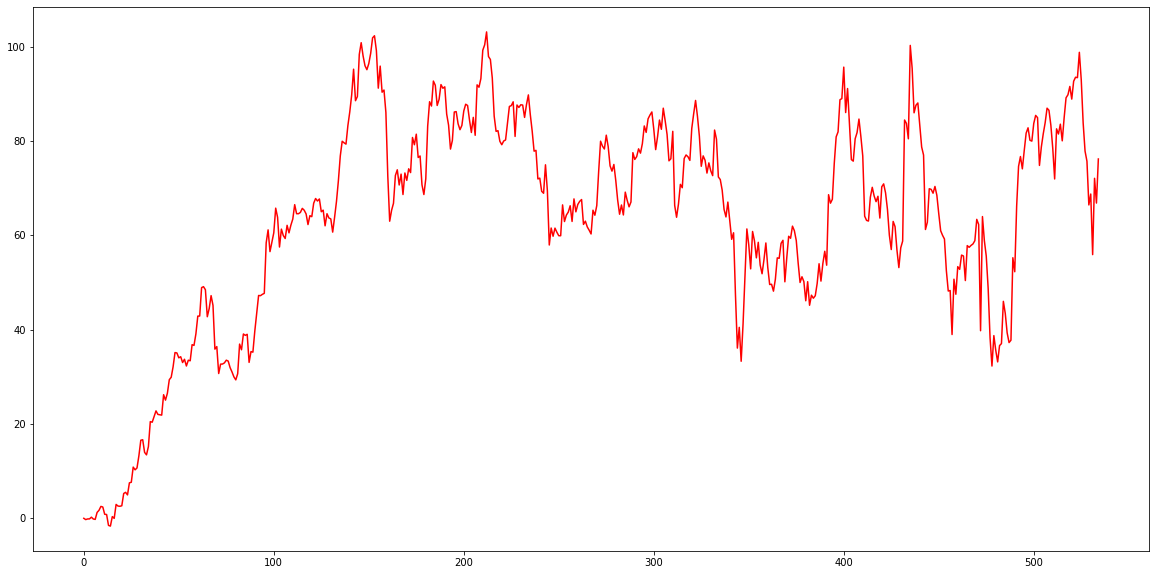

iter 90. reward: 916.222444
day 1606: buy 39 units at price 7353.840000, total balance 92646.160000
day 1607: buy 15 units at price 2721.750000, total balance 89924.410000
day 1608: buy 2 units at price 367.540000, total balance 89556.870000
day 1609: buy 8 units at price 1471.439920, total balance 88085.430080
day 1610: buy 26 units at price 4905.160000, total balance 83180.270080
day 1611: buy 70 units at price 12951.400000, total balance 70228.870080
day 1612: buy 39 units at price 7196.280000, total balance 63032.590080
day 1613: buy 1 units at price 191.170000, total balance 62841.420080
day 1614: buy 31 units at price 5987.340000, total balance 56854.080080
day 1615: buy 1 units at price 196.649990, total balance 56657.430090
day 1616: buy 1 units at price 196.120000, total balance 56461.310090
day 1617: buy 24 units at price 4549.680240, total balance 51911.629850
day 1618: buy 41 units at price 7765.399590, total balance 44146.230260
day 1619: buy 32 units at price 5820.160000,

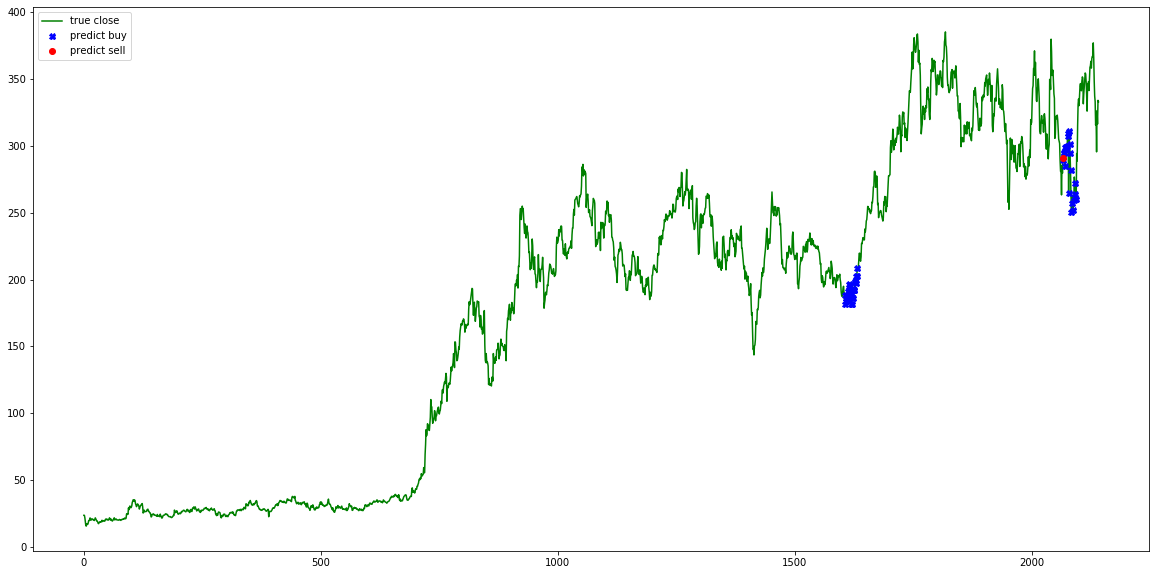

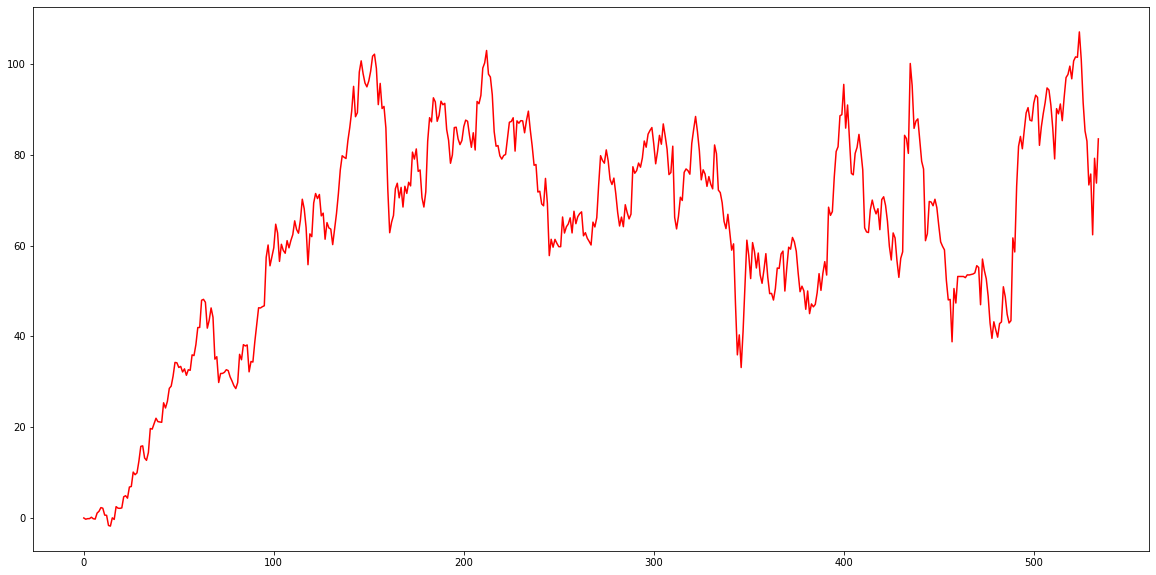

iter 95. reward: 1007.076061
day 1606: buy 45 units at price 8485.200000, total balance 91514.800000
day 1607: buy 3 units at price 544.350000, total balance 90970.450000
day 1608: buy 20 units at price 3675.400000, total balance 87295.050000
day 1609: buy 22 units at price 4046.459780, total balance 83248.590220
day 1610: buy 24 units at price 4527.840000, total balance 78720.750220
day 1611: buy 70 units at price 12951.400000, total balance 65769.350220
day 1612: buy 45 units at price 8303.400000, total balance 57465.950220
day 1613: buy 1 units at price 191.170000, total balance 57274.780220
day 1614: buy 29 units at price 5601.060000, total balance 51673.720220
day 1615: buy 1 units at price 196.649990, total balance 51477.070230
day 1616: buy 1 units at price 196.120000, total balance 51280.950230
day 1617: buy 31 units at price 5876.670310, total balance 45404.279920
day 1618: buy 63 units at price 11932.199370, total balance 33472.080550
day 1619: buy 27 units at price 4910.7600

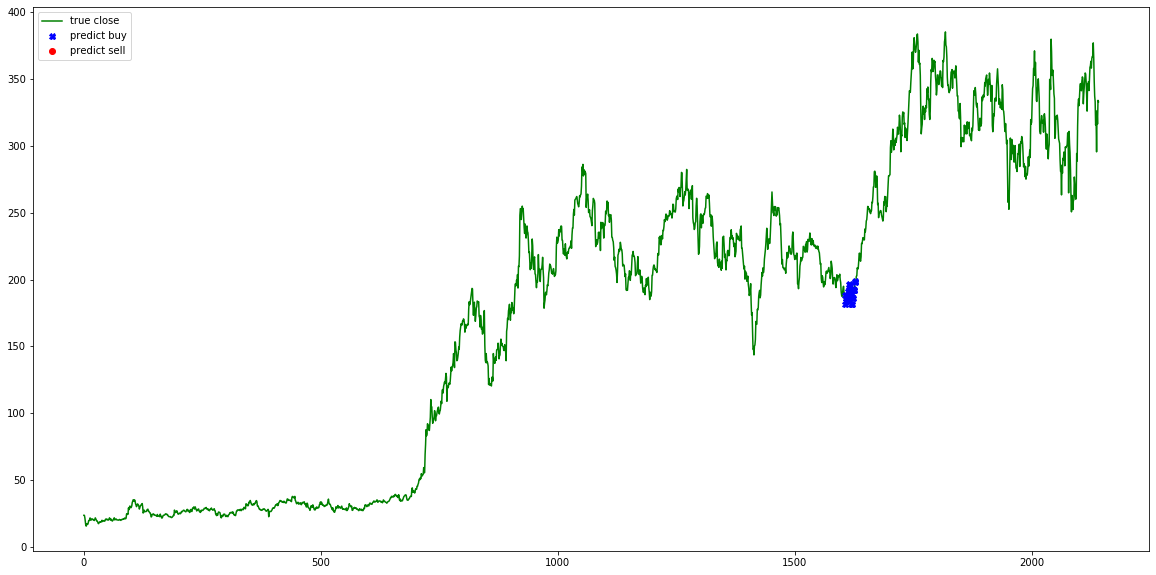

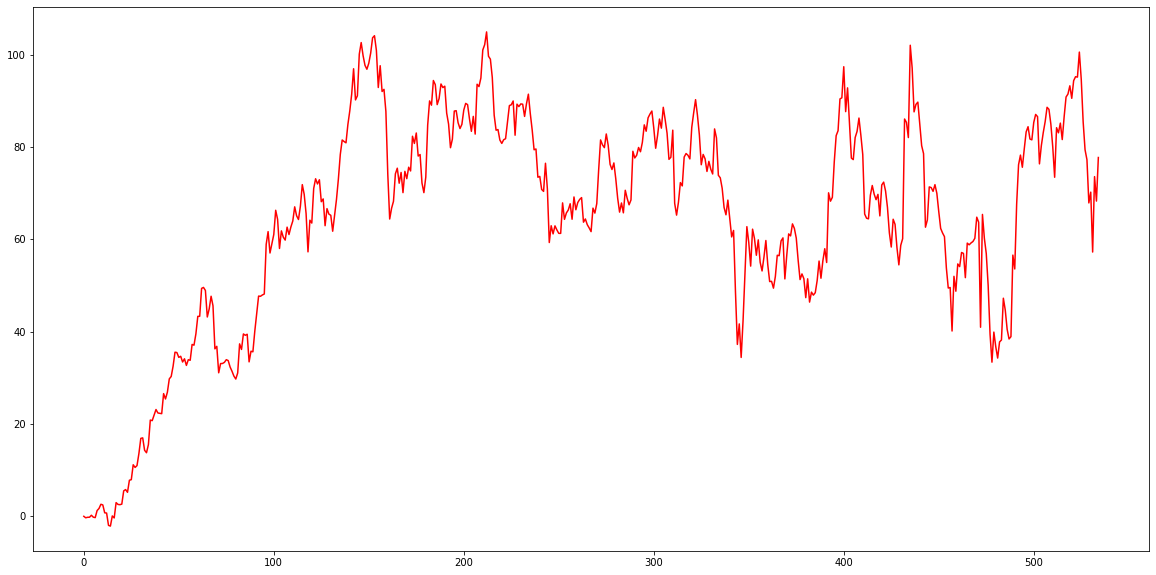

iter 100. reward: 1046.198947
day 1606: buy 45 units at price 8485.200000, total balance 91514.800000
day 1607: buy 17 units at price 3084.650000, total balance 88430.150000
day 1608: buy 20 units at price 3675.400000, total balance 84754.750000
day 1609: buy 23 units at price 4230.389770, total balance 80524.360230
day 1610: buy 18 units at price 3395.880000, total balance 77128.480230
day 1611: buy 59 units at price 10916.180000, total balance 66212.300230
day 1612: buy 52 units at price 9595.040000, total balance 56617.260230
day 1613: buy 1 units at price 191.170000, total balance 56426.090230
day 1614: buy 23 units at price 4442.220000, total balance 51983.870230
day 1615: buy 1 units at price 196.649990, total balance 51787.220240
day 1616: buy 1 units at price 196.120000, total balance 51591.100240
day 1617: buy 3 units at price 568.710030, total balance 51022.390210
day 1618, sell 263 units at price 49812.197370, total balance 100834.587580,
day 1619: buy 21 units at price 3819

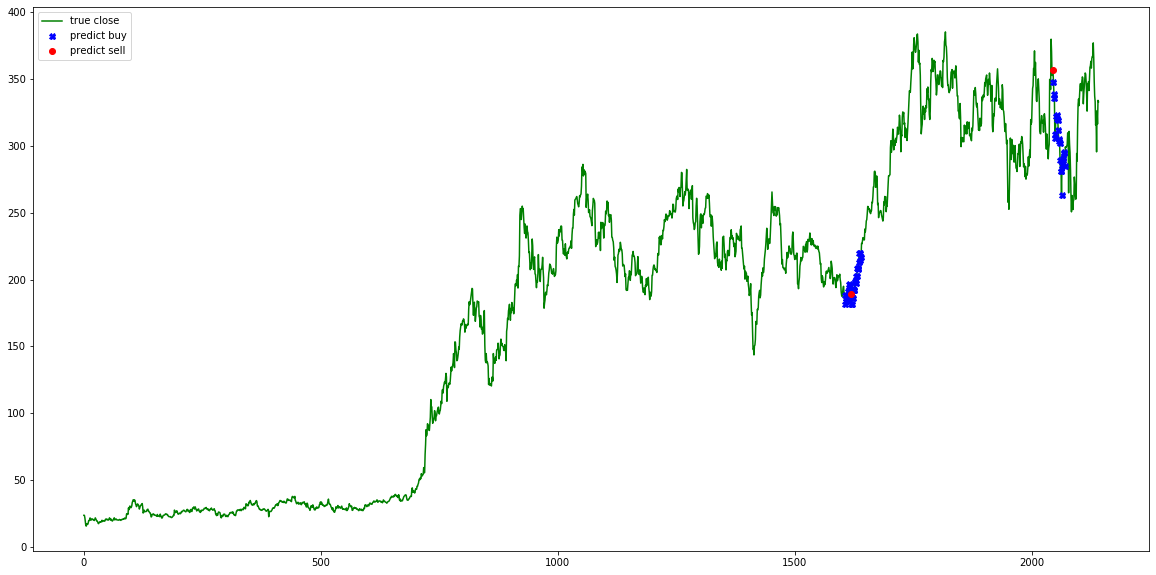

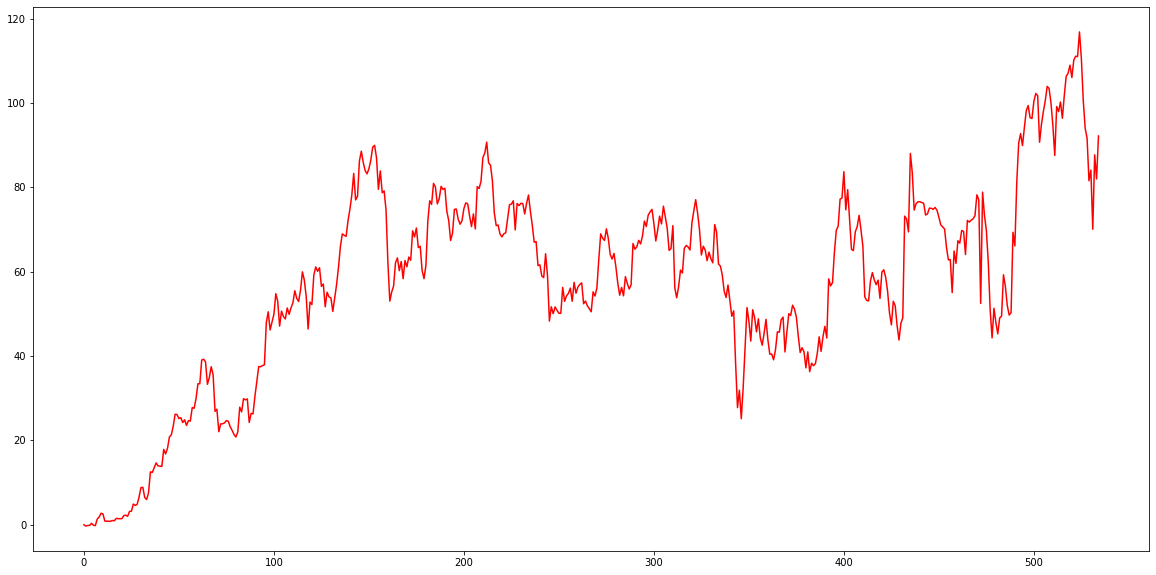

day 1606: buy 45 units at price 8485.200000, total balance 91514.800000
day 1607: buy 17 units at price 3084.650000, total balance 88430.150000
day 1608: buy 20 units at price 3675.400000, total balance 84754.750000
day 1609: buy 23 units at price 4230.389770, total balance 80524.360230
day 1610: buy 18 units at price 3395.880000, total balance 77128.480230
day 1611: buy 59 units at price 10916.180000, total balance 66212.300230
day 1612: buy 52 units at price 9595.040000, total balance 56617.260230
day 1613: buy 1 units at price 191.170000, total balance 56426.090230
day 1614: buy 23 units at price 4442.220000, total balance 51983.870230
day 1615: buy 1 units at price 196.649990, total balance 51787.220240
day 1616: buy 1 units at price 196.120000, total balance 51591.100240
day 1617: buy 3 units at price 568.710030, total balance 51022.390210
day 1618, sell 263 units at price 49812.197370, total balance 100834.587580,
day 1619: buy 21 units at price 3819.480000, total balance 97015.1

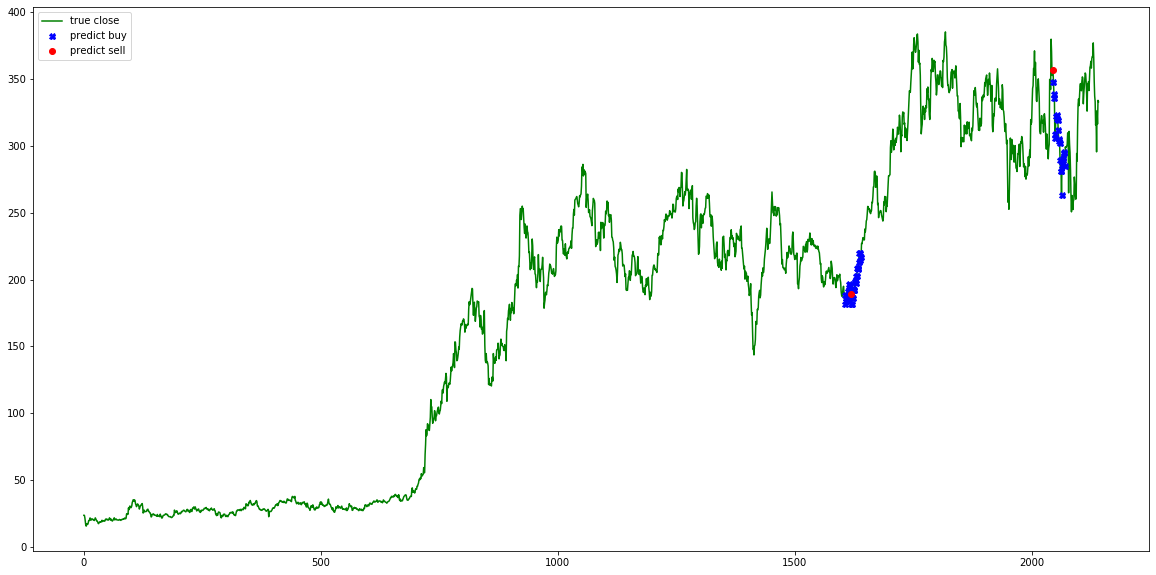

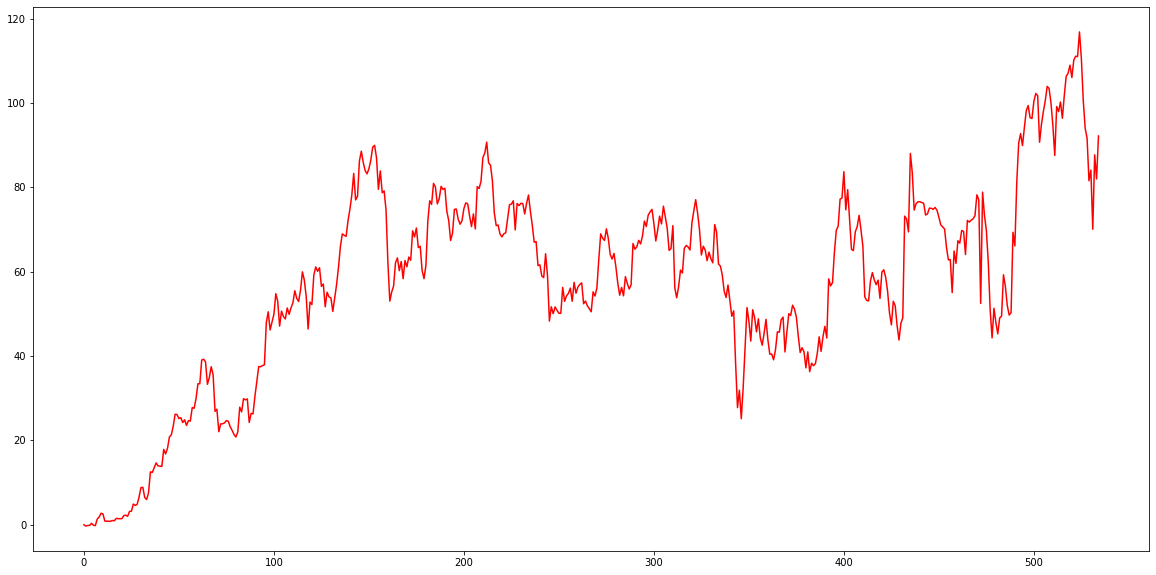

time taken to train: 1231.5668287277222 seconds


In [13]:
model = Model(input_size = 30*3, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 50, 
              sigma = 0.1, 
              learning_rate = 0.02, 
              model = model, 
              money = 100000,  
              skip = 1, 
              window_size = 30)
agent.fit(100, 5)

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)